# **AIML CA2 Assignment - Part B (Time-Series Forecasting)**
**Name**: JEROME LOKE  
**Student ID**: P2510707  
**Class**: DAAA/FT/1B/01  

---

### **Tasks, and how I fulfilled them**
##### → _"Evaluate model performance and tune its hyperparameters to maximize the accuracy for training data and testing data predictions. Remember to use validation and test data properly."_


##### → _"Implement the machine learning workflow for training time series models on the given dataset. You should use Statsmodels library to build the forecasting models."_


##### → _"Use appropriate charts to display the models’ behaviour and performance."_


### **Machine Learning Workflow**
1. EDA

2. Preprocessing & Feature Engineering

3. Modelling & Evaluation

4. Model Improvement  
4.1. 60-Month Future Forecast

---

### Import Libraries

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# EDA, Preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox 

# Modelling
from sklearn.model_selection import TimeSeriesSplit
# from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.special import inv_boxcox

import warnings
warnings.filterwarnings('ignore')

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

C:\Users\lokej\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


---

## **STAGE 1: EDA (Exploratory Data Analysis)**
* **Preview Dataset**: Display first 5 rows to understand its structure.
* **Handle Time Index**: Convert date column to DatetimeIndex, set monthly frequency to 'MS' (month-start)
* **Rename Columns**: Remove whitespace in feature names by converting them to snake case (e.g. `Gas Consumption (tons)` → `gas_tons`)
* **Check Missing Dates**: Check for any gaps in date index and check for rows with no date
* **Time Domain Analysis**: Plot the 3 energy type consumptions over time to inspect overall trend, seasonality and spikes/drops
* **Seasonal Decomposition**: Investigate trend, seasonality in conusmption data
* **Stationarity Analysis**: Check if all 3 energy type consumptions have constant mean, variance and no autocorrelation via
  * ADF test
  * KPSS test
  * Simple Moving Average / Rolling Mean & Variance

### Load & Preview Dataset

In [2]:
df = pd.read_csv("./CA2-datasets/CA2-Energy-Consumption-Data.csv")
print("Missing Values\n", df.isna().sum())

print("\ndf.info():")
df.info()

Missing Values
 DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [3]:
# handle time index
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y", errors="coerce") # convert date column to DatetimeIndex
df.set_index("DATE", inplace=True)
df = df.asfreq("MS")

df.head()

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   

            Water Consumption (tons)  
DATE                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4

### Rename Columns

In [4]:
df.rename(columns={
  "Gas Consumption (tons)": "gas_tons",
  "Electricity Consumption (MWh)": "electricity_mwh",
  "Water Consumption (tons)": "water_tons"
}, inplace=True)
df.head(1)

gas_tons  electricity_mwh  water_tons
DATE                                             
1990-01-01      18.0            725.1       548.8

### Check Missing Dates & Data

In [5]:
df.isna().any()

gas_tons           False
electricity_mwh    False
water_tons         False
dtype: bool

In [6]:
# expected monthly frequency
expected = pd.date_range(
  start=df.index.min(),
  end=df.index.max(),
  freq='MS'
)

missing_dates = expected.difference(df.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

- No missing dates or gaps in our dataset

### Time Domain Analysis

Plotting
* Gas consumption over time

* Electricity consumption over time

* Water consumption over time


To get a better idea of overall trend, seasonality, and sudden spikes or drops.

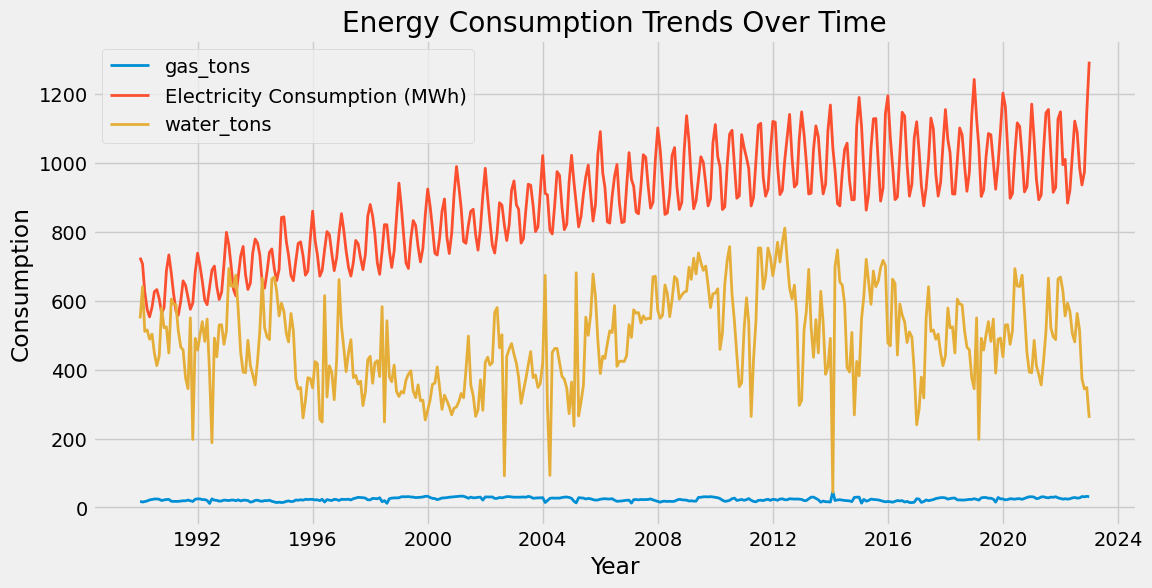

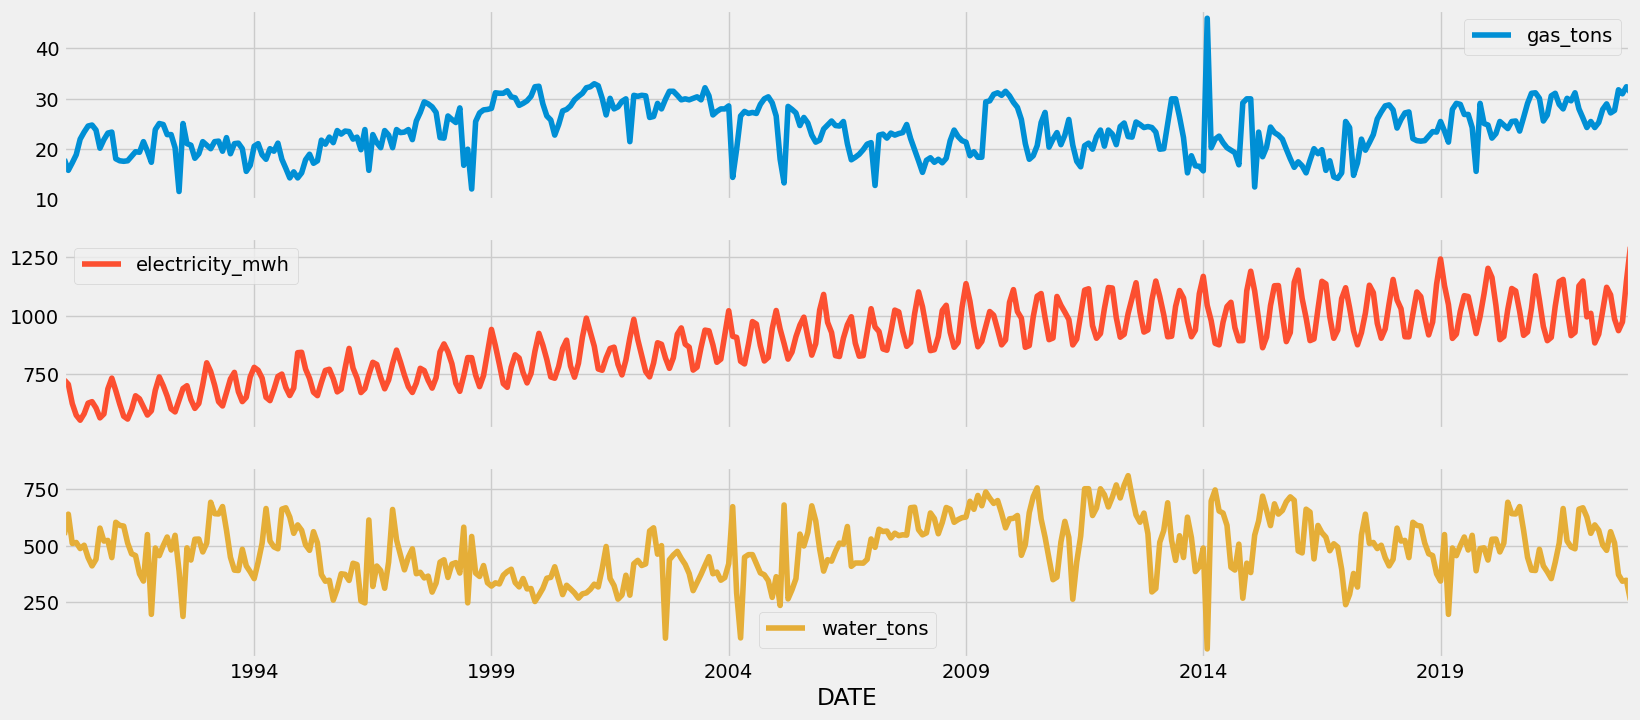

In [7]:
plt.figure(figsize=(12, 6))

# plot each energy type
plt.plot(df.index, df['gas_tons'], label='gas_tons', linewidth=2)
plt.plot(df.index, df['electricity_mwh'], label='Electricity Consumption (MWh)', linewidth=2)
plt.plot(df.index, df['water_tons'], label='water_tons', linewidth=2)

# style
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.title("Energy Consumption Trends Over Time")
plt.grid(True)
plt.legend()
plt.show()

# plotting each on its own
df.plot(subplots=True, figsize=(18, 8))
plt.show()

### Seasonal Decompose
- Is trend linear/flat?
- Is there clear seasonality?
- Are residuals stationary?

In [8]:
consumption_types = [
  'electricity_mwh',
  'water_tons',
  'gas_tons'
]

cons_pal = {
  'electricity_mwh': "#FFA500",
  'water_tons': "#1E90FF",
  'gas_tons': "#1B7E1B"
}

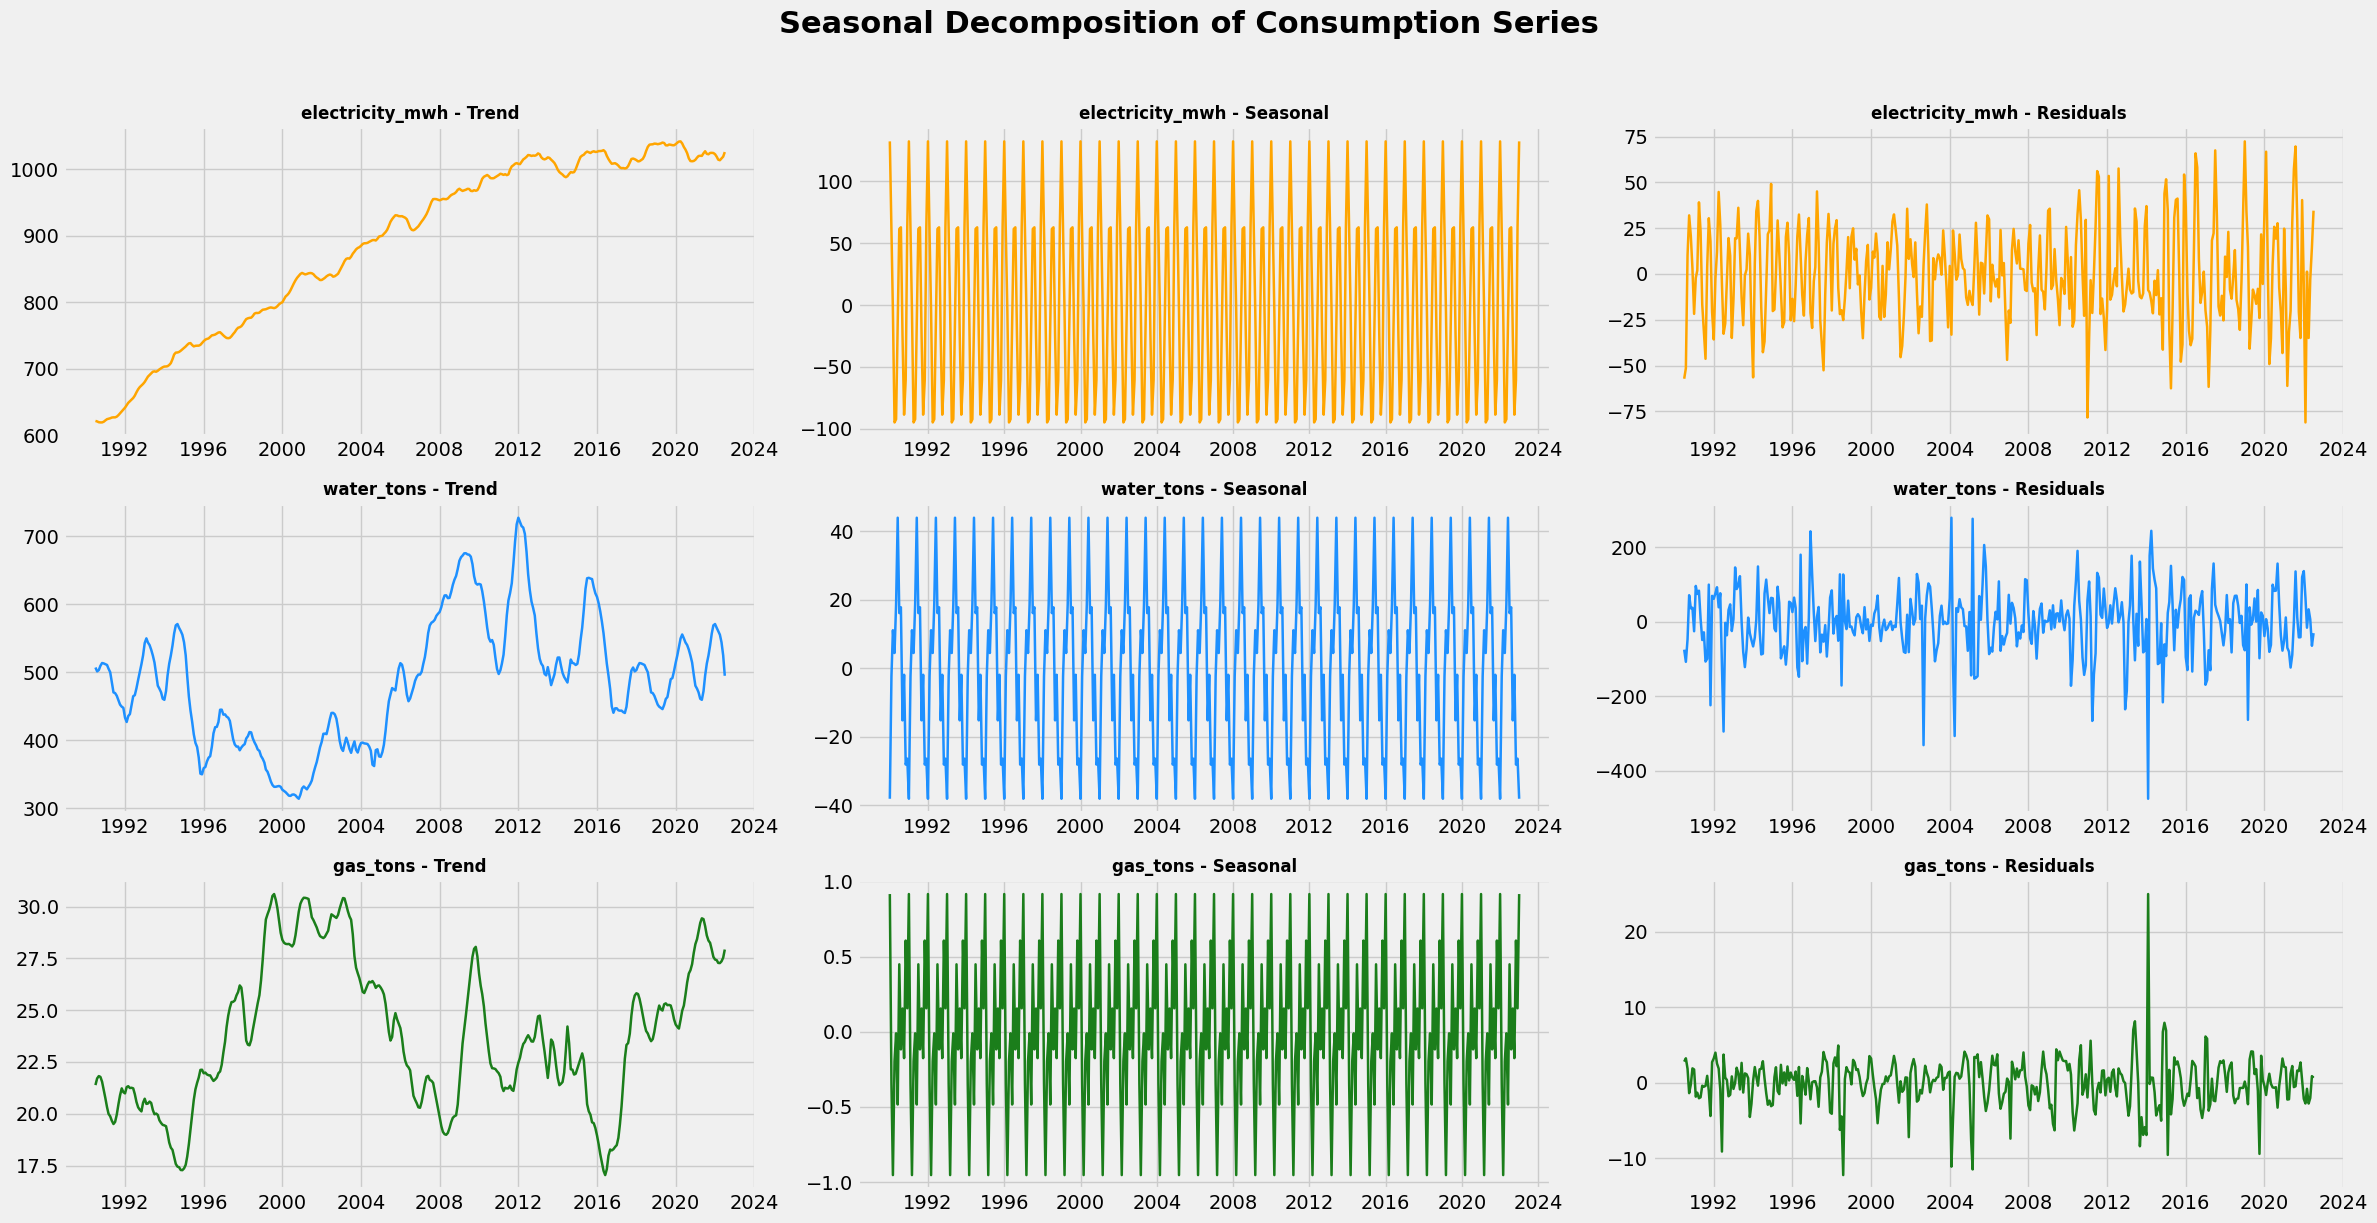

In [9]:
fig, axes = plt.subplots(len(consumption_types), 3, figsize=(24, 12))
fig.suptitle("Seasonal Decomposition of Consumption Series", fontsize=22, fontweight='bold', y=1.02)

for i, c_type in enumerate(consumption_types):
  series = df[c_type]
  
  # Decompose (additive; use multiplicative if variance grows with level)
  result = seasonal_decompose(series, model='additive', period=12)
  
  # Trend
  axes[i, 0].plot(result.trend, color=cons_pal[c_type], linewidth=1.8)
  axes[i, 0].set_title(f"{c_type} - Trend", fontsize=12, fontweight='bold')
  
  # Seasonal
  axes[i, 1].plot(result.seasonal, color=cons_pal[c_type], linewidth=1.8)
  axes[i, 1].set_title(f"{c_type} - Seasonal", fontsize=12, fontweight='bold')
  
  # Residuals
  axes[i, 2].plot(result.resid, color=cons_pal[c_type], linewidth=1.8)
  axes[i, 2].set_title(f"{c_type} - Residuals", fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

### Stationarity Analysis
ARIMA expects stationary data (constant mean, variance and autocorrelation over time). This stability makes the data predictable, as its behavior is not dependent on the observation time.

##### Simple Moving Average
Check trend, seasonality and constant variance across the 3 energy types.

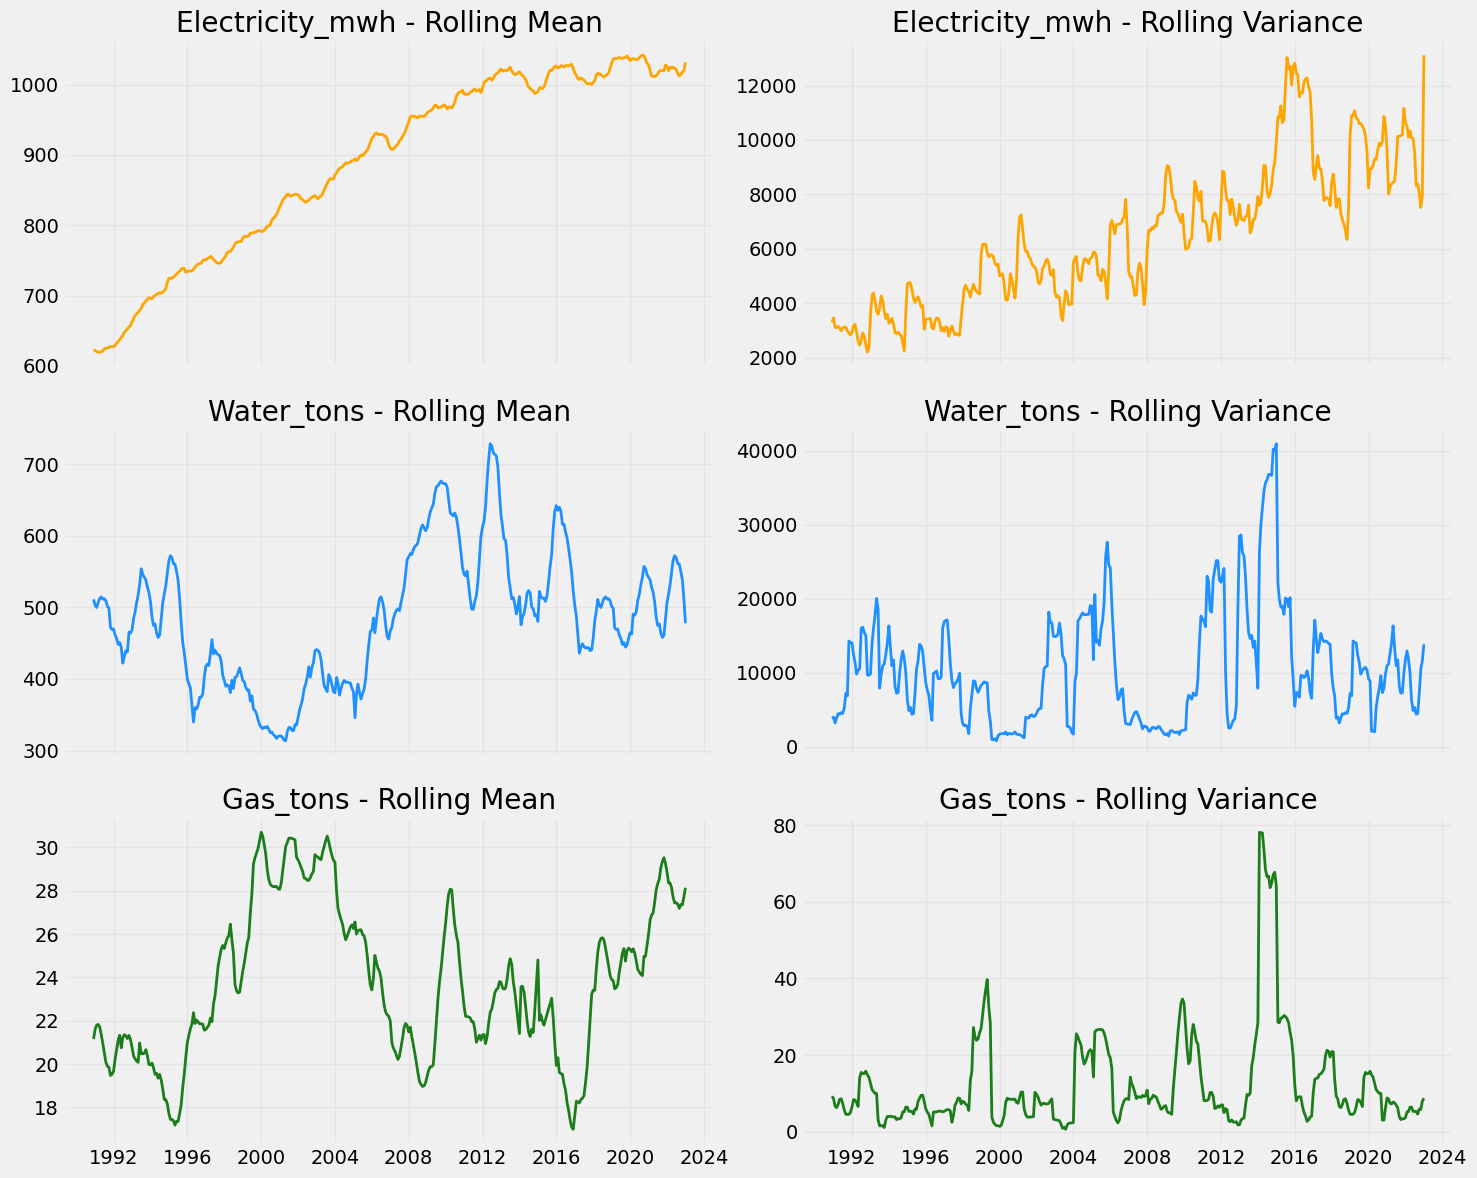

In [10]:
rolling_window = 12 # months

fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

for i, col in enumerate(consumption_types):
  rolling_mean = df[col].rolling(rolling_window).mean()
  rolling_var = df[col].rolling(rolling_window).var()

  # plot rolling mean
  axes[i, 0].plot(df.index, rolling_mean, linewidth=2, color=cons_pal[col])
  axes[i, 0].set_title(f"{col.capitalize()} - Rolling Mean")

  # plot rolling variance
  axes[i, 1].plot(df.index, rolling_var, linewidth=2, color=cons_pal[col])
  axes[i, 1].set_title(f"{col.capitalize()} - Rolling Variance")

for ax in axes.flatten():
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Electricity Consumption**
- Rolling mean shows strong upward trend, followed by a period of slower, more erratic growth around 2014 → suggests long-term non-stationarity in the mean.
- Rolling variance increases steadily over time → suggests **heteroskedasticity** (variability grows with consumption level).

**Water Consumption**
- Rolling mean does not show a consistent long-term trend. Displays multiple periods of rising and falling demand.
- Rolling variance has lots of large spikes, indicating strong non-stationarity in variance, likely driven by external factors like policies.

**Gas Consumption**  
- Rolling mean shows moderate changes, likely due to regime shifts rather than a persistent trend. 
- Rolling variance is generally low though there are volatile spikes around 1999, 2004, 2010 and especially 2014. This suggests episodic shocks rather than sustained growth.

**Conclusion**  
Across all three series, no clear seasonality is visible at the rolling-mean level; however, this may be partially due to the smoothing effect of the 12-month window, which suppresses seasonal fluctuations.  
Overall, the SMA analysis suggests that all series are non-stationary in mean, while electricity and water also exhibit clear variance instability. Formal stationarity tests (ADF/KPSS) are therefore required to validate these visual findings. Variance-stabilising transformations such as Box-Cox are particularly appropriate for electricity and water consumption, while gas consumption may require only mild transformation or robust modelling approaches.

#### ADF (Augmented Dickey-Fuller) Test


In [11]:
def adf_test(series, name=""):
  result = adfuller(series.dropna())

  print(f"ADF Test for {name}")
  print(f"Test Statistic: {result[0]:.4f}")
  print(f"p-value: {result[1]:.4f}")
  print("Critical Values:")

  for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

  if result[1] < 0.05:
    print("Conclusion: Reject H0 → Series is stationary")
  else:
    print("Conclusion: Fail to reject H0 → Series is non-stationary")

  print("\n")

adf_test(df['electricity_mwh'], "Electricity Consumption")
adf_test(df['water_tons'], "Water Consumption")
adf_test(df['gas_tons'], "Gas Consumption")

ADF Test for Electricity Consumption
Test Statistic: -2.2570
p-value: 0.1862
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Fail to reject H0 → Series is non-stationary


ADF Test for Water Consumption
Test Statistic: -4.6848
p-value: 0.0001
Critical Values:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707
Conclusion: Reject H0 → Series is stationary


ADF Test for Gas Consumption
Test Statistic: -3.4044
p-value: 0.0108
Critical Values:
   1%: -3.4472
   5%: -2.8690
   10%: -2.5707
Conclusion: Reject H0 → Series is stationary




#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [12]:
def kpss_test(series, name="", regression="c"):
  statistic, p_value, lags, critical_values = kpss(
    series.dropna(),
    regression=regression,
    nlags="auto"
  )

  print(f"KPSS Test for {name}")
  print(f"Test Statistic: {statistic:.4f}")
  print(f"p-value: {p_value:.4f}")
  print("Critical Values:")

  for key, value in critical_values.items():
    print(f"   {key}: {value}")

  if p_value < 0.05:
    print("Conclusion: Reject H0 → Series is non-stationary")
  else:
    print("Conclusion: Fail to reject H0 → Series is stationary")
  print("\n")

kpss_test(df['electricity_mwh'], "Electricity Consumption")
kpss_test(df['water_tons'], "Water Consumption")
kpss_test(df['gas_tons'], "Gas Consumption")

KPSS Test for Electricity Consumption
Test Statistic: 3.5316
p-value: 0.0100
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject H0 → Series is non-stationary


KPSS Test for Water Consumption
Test Statistic: 0.8388
p-value: 0.0100
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject H0 → Series is non-stationary


KPSS Test for Gas Consumption
Test Statistic: 0.3402
p-value: 0.1000
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Fail to reject H0 → Series is stationary




#### Interpret ADF & KPSS Results
![How to interpret ADF and KPSS](interpret_ADF_KPSS.png)  


**Summary of Results**
| Energy Type | ADF p-value | ADF Conclusion | KPSS p-value | KPSS Conclusion | Overall Stationarity |
|-----------|------------|---------------|-------------|----------------|---------------------|
| Electricity | 0.1862 | Non-stationary | 0.0100 | Non-stationary | **Non-stationary** |
| Water | 0.0001 | Stationary | 0.0100 | Non-stationary | **Inconclusive (trend-stationary)** |
| Gas | 0.0108 | Stationary | 0.1000 | Stationary | **Stationary** |

Electricity
- Both ADF and KPSS tests indicate changing mean over time. Differencing required.

Water
- ADF suggests stationarity, while KPSS rejects it, indicating trend-stationarity. Differencing or detrending required.

Gas
- Both ADF and KPSS tests suggest stationarity. Differencing not required.

_Note: The KPSS interpolation warnings indicate very strong evidence for the conclusions and do not invalidate the results._

---

## **STAGE 2: Preprocessing & Feature Engineering**

### Box-Cox transform
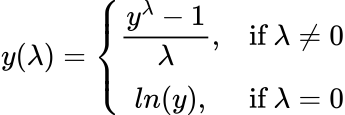

Lambda value is estimated by maximising the likelihood of the transformed original series. It tells us what power should be applied to the raw data distribution.

Box–Cox reshapes the data distribution to make it:
- more symmetric
- less right-skewed
- more constant in variance over time

#### Calculate λ
Decide if Box-Cox is necessary for each feature.

In [13]:
ys_bc = {}
lambdas_bc = {}

for type in consumption_types:
  y = df[type]
  y_bc, lambda_bc = boxcox(y)
  ys_bc[type] = y_bc
  lambdas_bc[type] = lambda_bc

lambdas_bc

{'electricity_mwh': np.float64(1.074887946525938),
 'water_tons': np.float64(1.0426534628565798),
 'gas_tons': np.float64(0.7801343902718498)}

- Water and Electricity consumption do not require boxcox as their lambda values (~1.04 & ~1.07 respectively) are very near 1. Applying the transformation would effect minimal changes to the data.

- Gas consumption shows mild right skew, Box–Cox can gently compress the data.

- **NOTE:** After performing first-order differencing on Electricity consumption, I noticed that the differenced series' rolling variance still shows a mild upward trend (not constant). Thus, I backtracked and applied box-cox to it too.

#### Box-Cox Transform

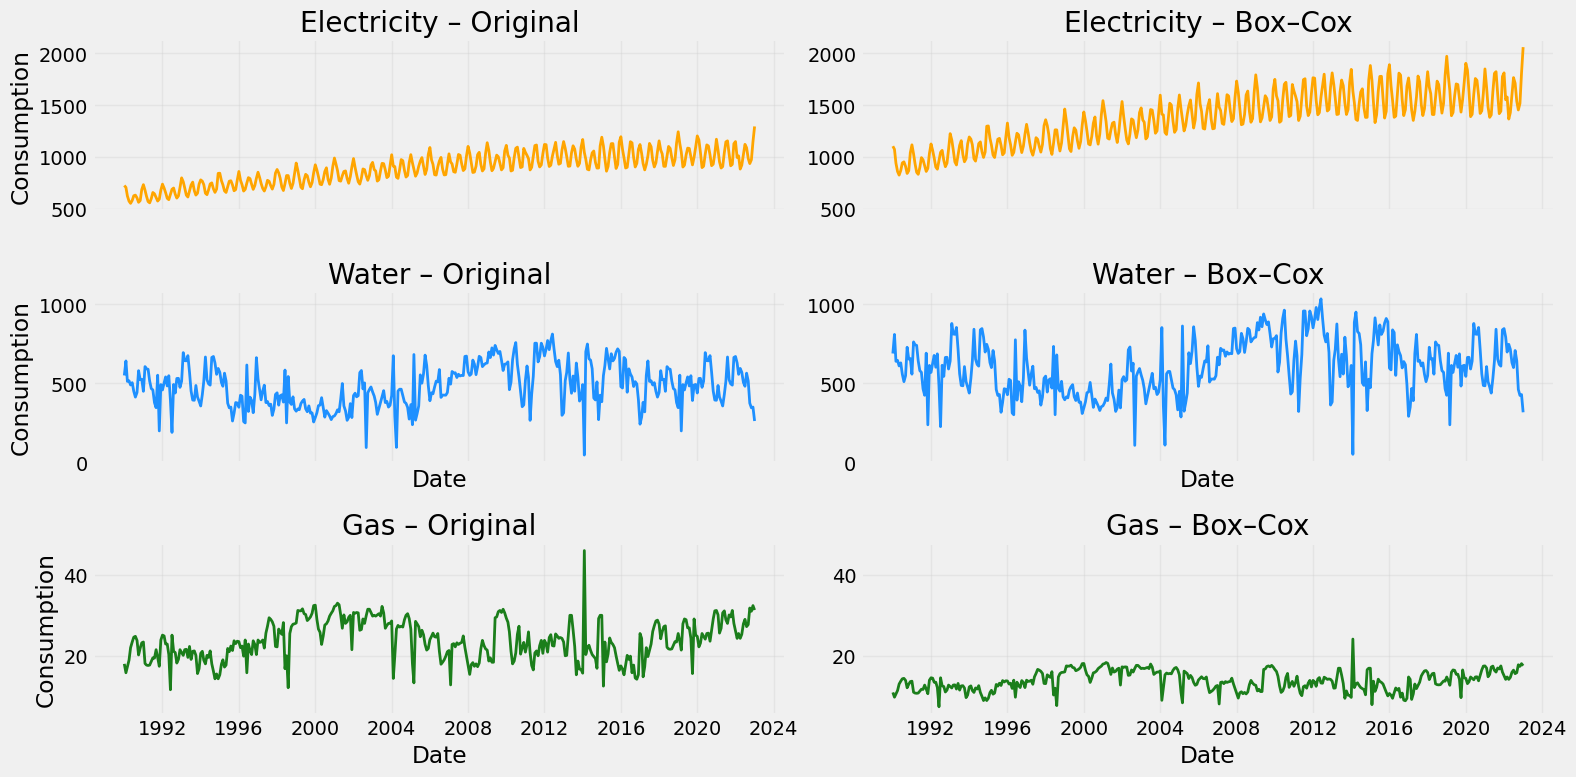

In [14]:
# Apply Box-Cox transform
df["electricity_mwh_bc"] = ys_bc["electricity_mwh"]
df["water_tons_bc"] = ys_bc["water_tons"]
df["gas_tons_bc"] = ys_bc["gas_tons"]

fig, ax = plt.subplots(3, 2, figsize=(16, 8), sharex=True)

# 1. Electricity Consumption
# Original
ax[0, 0].plot(df.index, df["electricity_mwh"],
              linewidth=2, color=cons_pal["electricity_mwh"])
ax[0, 0].set_title("Electricity – Original")
ax[0, 0].set_ylabel("Consumption")
ax[0, 0].grid(True, alpha=0.3)

# Box–Cox
ax[0, 1].plot(df.index, df["electricity_mwh_bc"],
              linewidth=2, color=cons_pal["electricity_mwh"])
ax[0, 1].set_title("Electricity – Box–Cox")
ax[0, 1].grid(True, alpha=0.3)
ax[0, 1].sharey(ax[0, 0])

# 2. Water Consumption
# Original
ax[1, 0].plot(df.index, df["water_tons"],
              linewidth=2, color=cons_pal["water_tons"])
ax[1, 0].set_title("Water – Original")
ax[1, 0].set_ylabel("Consumption")
ax[1, 0].set_xlabel("Date")
ax[1, 0].grid(True, alpha=0.3)

# Box–Cox
ax[1, 1].plot(df.index, df["water_tons_bc"],
              linewidth=2, color=cons_pal["water_tons"])
ax[1, 1].set_title("Water – Box–Cox")
ax[1, 1].set_xlabel("Date")
ax[1, 1].grid(True, alpha=0.3)
ax[1, 1].sharey(ax[1, 0])

# 3. Gas Consumption
# Original
ax[2, 0].plot(df.index, df["gas_tons"],
              linewidth=2, color=cons_pal["gas_tons"])
ax[2, 0].set_title("Gas – Original")
ax[2, 0].set_ylabel("Consumption")
ax[2, 0].set_xlabel("Date")
ax[2, 0].grid(True, alpha=0.3)

# Box–Cox
ax[2, 1].plot(df.index, df["gas_tons_bc"],
              linewidth=2, color=cons_pal["gas_tons"])
ax[2, 1].set_title("Gas – Box–Cox")
ax[2, 1].set_xlabel("Date")
ax[2, 1].grid(True, alpha=0.3)
ax[2, 1].sharey(ax[2, 0])

plt.tight_layout()
plt.show()

Effects of the Box-Cox Transformation:
- **Electricity Consumption**: Extrapolated values to stabilise variance 
- **Gas Consumption**: Compressed high gas consumption values, reduced right skewness and stabilised variance, giving a smoother and more model-ready time series.

### First-Order Differencing

In [15]:
def plot_series(
  series,
  title,
  ax,
  rolling_window=None,
  diff=False,
  color='blue',
  ylabel=None
):
  ax.plot(
    series,
    color=color,
    label='1st Difference' if diff else 'Original',
    linewidth=2
  )

  if rolling_window:
    ax.plot(
      series.rolling(rolling_window).mean(),
      'r--',
      label='Rolling Mean'
    )
    ax.plot(
      series.rolling(rolling_window).std(),
      'k--',
      label='Rolling Std'
    )

  ax.set_title(title)
  ax.set_xlabel('Date')

  if ylabel: ax.set_ylabel(ylabel)
  else: ax.set_ylabel('Value' + (' (Diff)' if diff else ''))
  ax.legend()

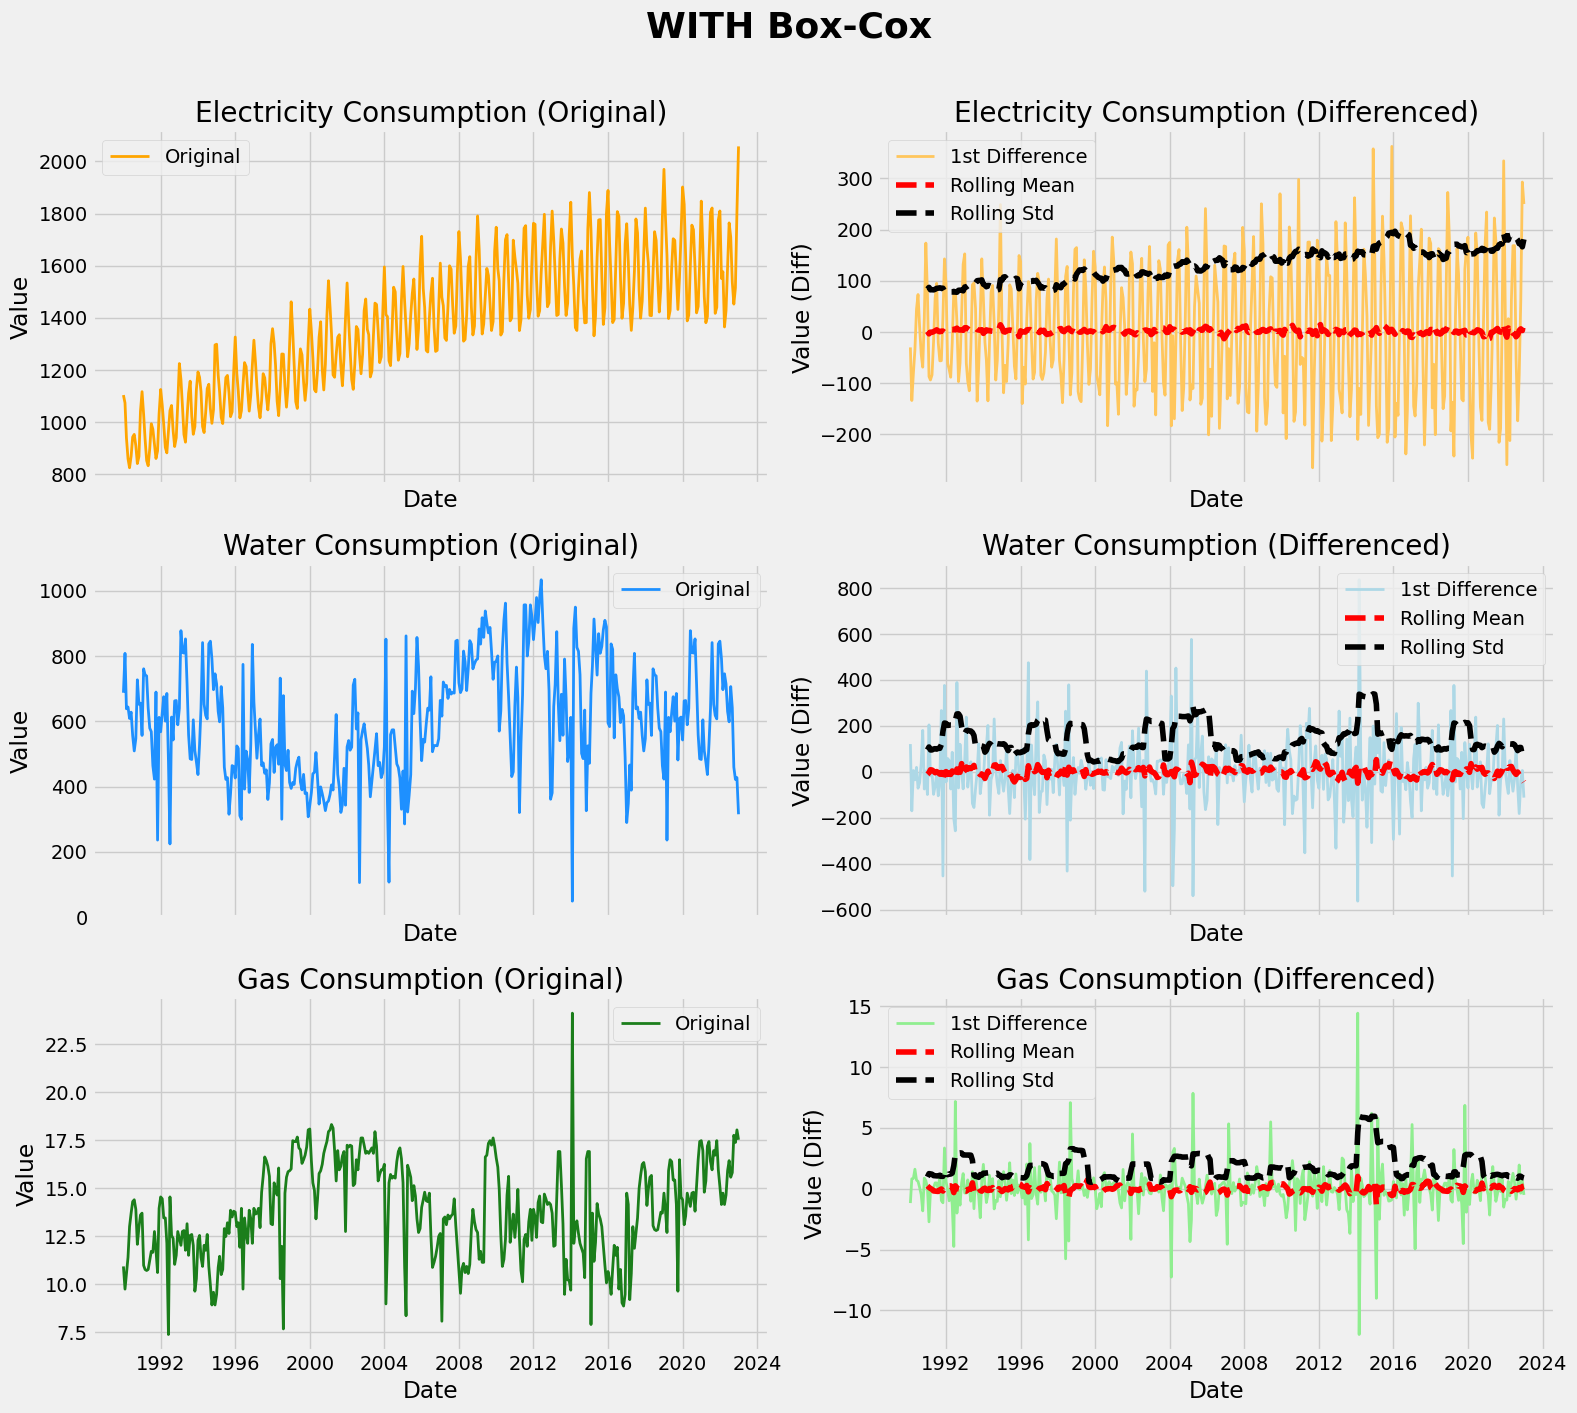

ADF Test for Box-Cox Electricity Consumption
Test Statistic: -7.1224
p-value: 0.0000
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary


ADF Test for Box-Cox Water Consumption
Test Statistic: -9.0621
p-value: 0.0000
Critical Values:
   1%: -3.4475
   5%: -2.8691
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary


ADF Test for Box-Cox Gas Consumption
Test Statistic: -7.8109
p-value: 0.0000
Critical Values:
   1%: -3.4477
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary




In [16]:
# first-order differencing after Box–Cox
df['electricity_bc_diff1'] = df['electricity_mwh_bc'].diff()
df['water_bc_diff1'] = df['water_tons_bc'].diff()
df['gas_bc_diff1'] = df['gas_tons_bc'].diff()

fig, ax = plt.subplots(3, 2, figsize=(16, 14), sharex=True)

# 1. Electricity
plot_series(
  df['electricity_mwh_bc'],
  title='Electricity Consumption (Original)',
  ax=ax[0, 0],
  color=cons_pal["electricity_mwh"]
)

plot_series(
  df['electricity_bc_diff1'],
  title='Electricity Consumption (Differenced)',
  ax=ax[0, 1],
  rolling_window=rolling_window,
  diff=True,
  color="#FFC65C"
)

# 2. Water
plot_series(
  df['water_tons_bc'],
  title='Water Consumption (Original)',
  ax=ax[1, 0],
  color=cons_pal["water_tons"]
)

plot_series(
  df['water_bc_diff1'],
  title='Water Consumption (Differenced)',
  ax=ax[1, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightblue'
)

# 3. Gas
plot_series(
  df['gas_tons_bc'],
  title='Gas Consumption (Original)',
  ax=ax[2, 0],
  color=cons_pal["gas_tons"]
)

plot_series(
  df['gas_bc_diff1'],
  title='Gas Consumption (Differenced)',
  ax=ax[2, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightgreen'
)

plt.suptitle("WITH Box-Cox", fontsize=26, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

adf_test(df["electricity_bc_diff1"], "Box-Cox Electricity Consumption")
adf_test(df["water_bc_diff1"], "Box-Cox Water Consumption")
adf_test(df["gas_bc_diff1"], "Box-Cox Gas Consumption")

### Try Log-Transform
Fix Heteroscedasticity (the variance of error terms/residuals is not constant across all levels of an independent variable)

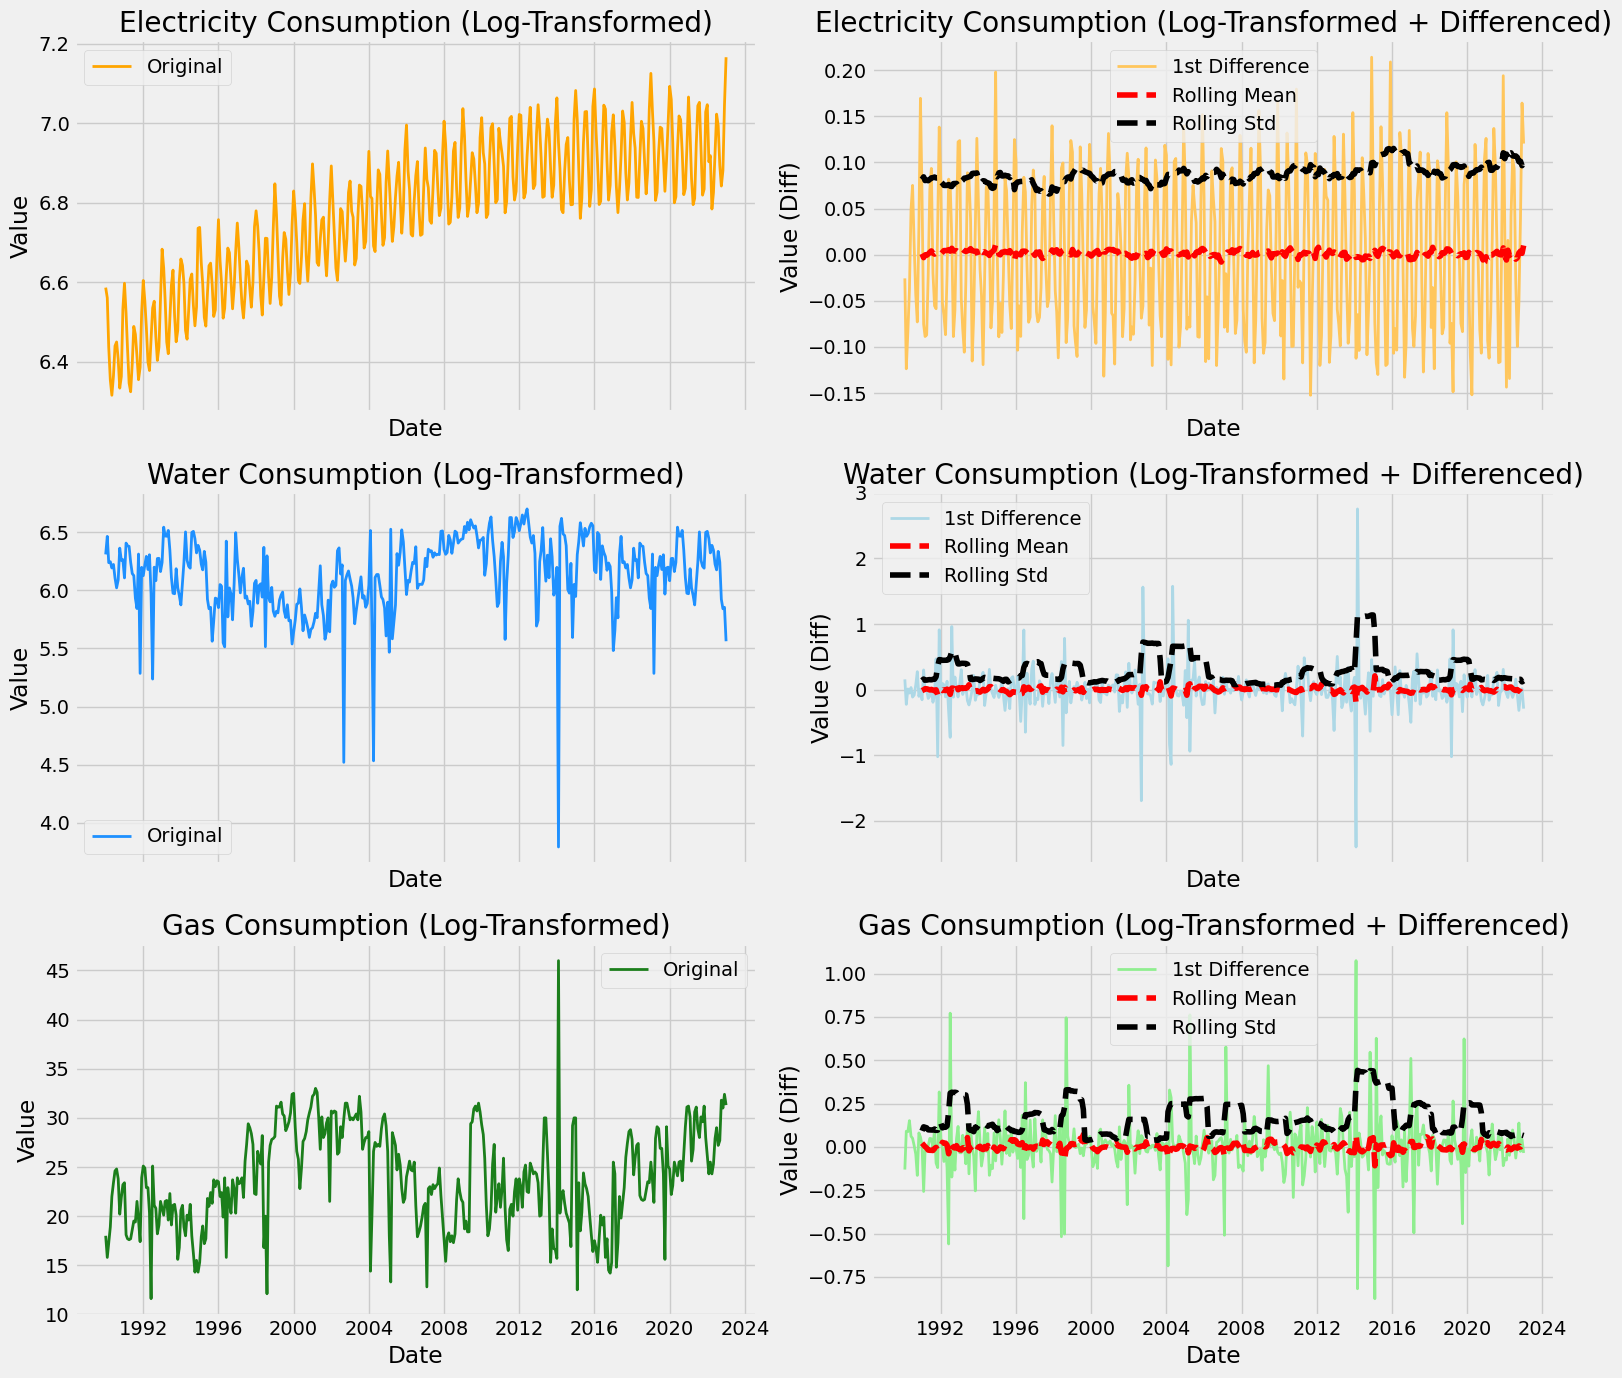

ADF Test for Log-Transformed Electricity Consumption
Test Statistic: -6.7482
p-value: 0.0000
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary


ADF Test for Log-Transformed Water Consumption
Test Statistic: -9.3343
p-value: 0.0000
Critical Values:
   1%: -3.4475
   5%: -2.8691
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary


ADF Test for Log-Transformed Gas Consumption
Test Statistic: -7.7382
p-value: 0.0000
Critical Values:
   1%: -3.4477
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary




In [17]:
# log-transform
df["electricity_mwh_log"] = np.log(df["electricity_mwh"])
df["water_tons_log"] = np.log(df["water_tons"])
df["gas_tons_log"] = np.log(df["gas_tons"])

# first-difference log-transformed data
df["electricity_log_diff1"] = df["electricity_mwh_log"].diff().dropna()
df["water_log_diff1"] = df["water_tons_log"].diff().dropna()
df["gas_log_diff1"] = df["gas_tons_log"].diff().dropna()

fig, ax = plt.subplots(3, 2, figsize=(16, 14), sharex=True)

# 1. Electricity
plot_series(
  df['electricity_mwh_log'],
  title='Electricity Consumption (Log-Transformed)',
  ax=ax[0, 0],
  color=cons_pal["electricity_mwh"]
)

plot_series(
  df['electricity_log_diff1'],
  title='Electricity Consumption (Log-Transformed + Differenced)',
  ax=ax[0, 1],
  rolling_window=rolling_window,
  diff=True,
  color='#FFC65C'
)

# 2. Water
plot_series(
  df['water_tons_log'],
  title='Water Consumption (Log-Transformed)',
  ax=ax[1, 0],
  color=cons_pal["water_tons"]
)

plot_series(
  df['water_log_diff1'],
  title='Water Consumption (Log-Transformed + Differenced)',
  ax=ax[1, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightblue'
)

# 3. Gas
plot_series(
  df['gas_tons'],
  title='Gas Consumption (Log-Transformed)',
  ax=ax[2, 0],
  color=cons_pal["gas_tons"]
)

plot_series(
  df['gas_log_diff1'],
  title='Gas Consumption (Log-Transformed + Differenced)',
  ax=ax[2, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightgreen'
)

plt.tight_layout()
plt.show()

adf_test(df["electricity_log_diff1"], "Log-Transformed Electricity Consumption")
adf_test(df["water_log_diff1"], "Log-Transformed Water Consumption")
adf_test(df["gas_log_diff1"], "Log-Transformed Gas Consumption")

### Autocorrelation Analysis
**Difference between ACF before and after modelling**
1. ACF (data) → “Is there structure I should model?”
2. ACF (residuals) → “Did my model remove all structure?”

**Aim of Pre-Modelling ACF PACF**
* Guide ARIMA parameters
  * Significant lags (see if lag sticks out beyond the confidence bound), especially if signifance is at Lag 12 → include AR terms
  * Seasonal spikes → include seasonal AR/MA (SARIMA)
* Check stationarity: slow decay means data still requires differencing

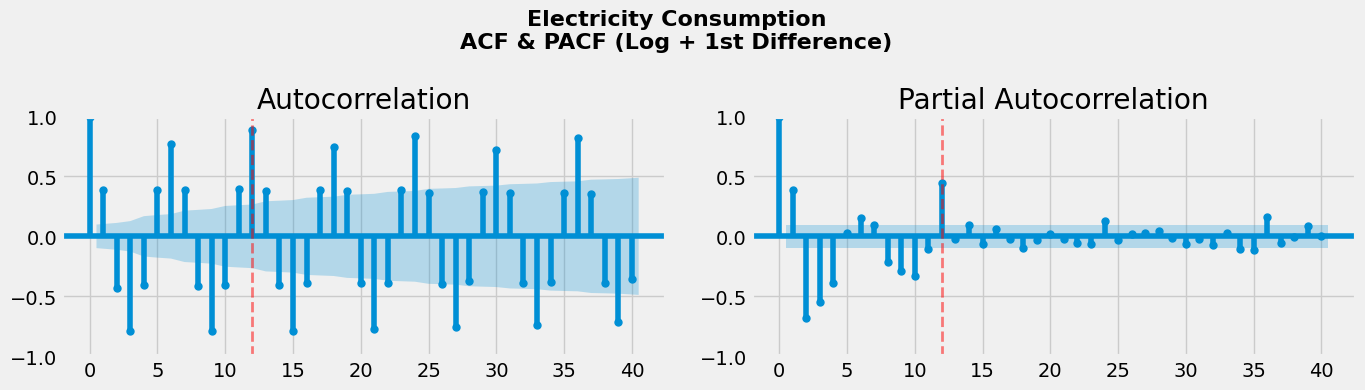

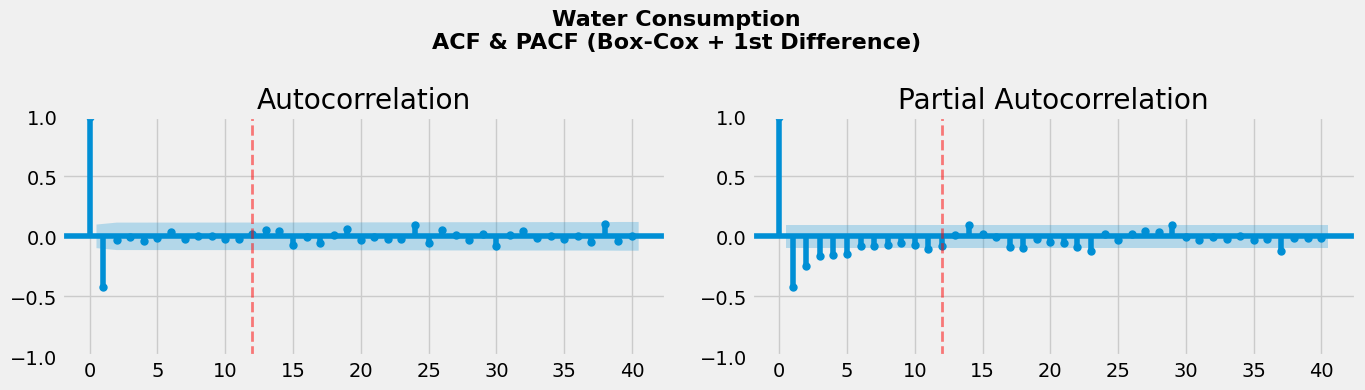

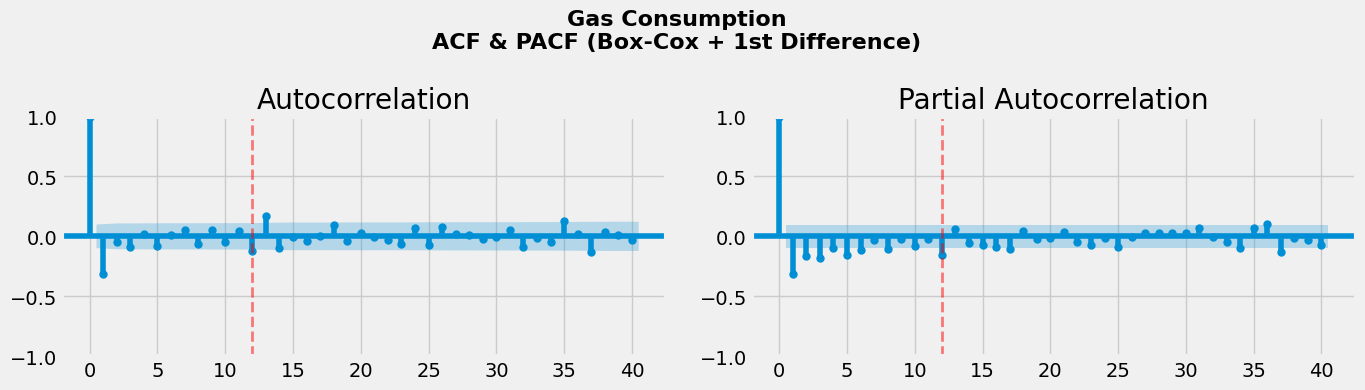

In [18]:
seasonal_lags = [12, 24]

# 1. Electricity
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['electricity_log_diff1'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['electricity_log_diff1'].dropna(), lags=40, ax=ax[1])
ax[0].axvline(12, linestyle='--', color='red', linewidth=2, alpha=0.5)
ax[1].axvline(12, linestyle='--', color='red', linewidth=2, alpha=0.5)

fig.suptitle("Electricity Consumption\nACF & PACF (Log + 1st Difference)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# 2. Water
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['water_log_diff1'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['water_log_diff1'].dropna(), lags=40, ax=ax[1])
ax[0].axvline(12, linestyle='--', color='red', linewidth=2, alpha=0.5)
ax[1].axvline(12, linestyle='--', color='red', linewidth=2, alpha=0.5)

fig.suptitle("Water Consumption\nACF & PACF (Box-Cox + 1st Difference)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# 3. Gas
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['gas_bc_diff1'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['gas_bc_diff1'].dropna(), lags=40, ax=ax[1])
ax[0].axvline(12, linestyle='--', color='red', linewidth=2, alpha=0.5)
ax[1].axvline(12, linestyle='--', color='red', linewidth=2, alpha=0.5)

fig.suptitle("Gas Consumption\nACF & PACF (Box-Cox + 1st Difference)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

##### Electricity Consumption (SARIMA, P=1)
**ACF**  

🔹 BIG Spikes @ Lag 12, 24, 36
  - Strong 12-month/annual seasonality
  - Confirms seasonal period = 12
  - **SARIMA will work better than ARIMA**
 
🔹 Slow decay instead of sharp cut-off

**PACF**  
🔹 Lag 1–2
  - Significant → AR(1) or AR(2) likely

🔹 Seasonal Spike @ Lag 12 → **Use seasonal AR(1)**

🔹 After Lag ~15 → mostly noise

##### Gas Consumption (ARIMA)
**ACF, PACF**  

🔹 Mild spike @ Lag 13 for ACF, likewise @ Lag 12 in PACF
  - Not much seasonality, ARIMA is suitable

### Seasonal Differencing
Our final preprocessing step after inspecting the ACF and PACF plots. They showed a strong seasonality of 12months, which is expected in our energy consumption data.

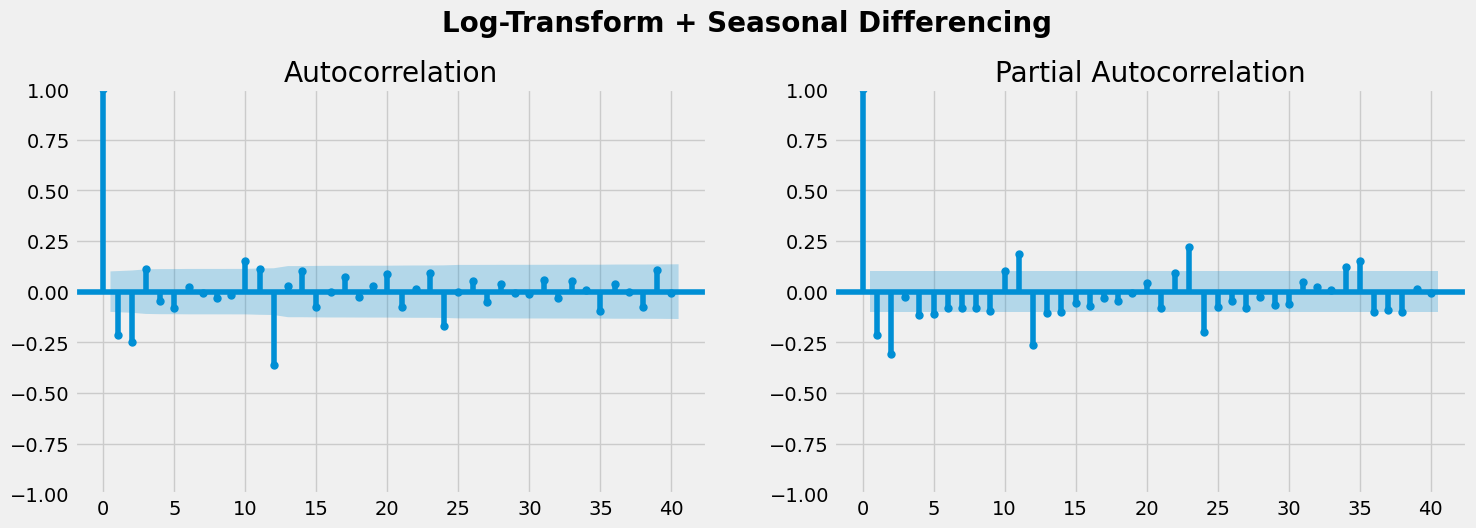

In [19]:
df["electricity_log_diff1_seasonal"] = df["electricity_log_diff1"].diff(12).dropna()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['electricity_log_diff1_seasonal'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['electricity_log_diff1_seasonal'].dropna(), lags=40, ax=ax[1])
plt.suptitle("Log-Transform + Seasonal Differencing", fontsize=20, fontweight="bold", y=1.04)
plt.show()

- Seasonal Differencing successfully removed most of the seasonality in our electricity consumption data, though there is still prominent 12-month seasonality as seen from the large negative spike at Lag 12.

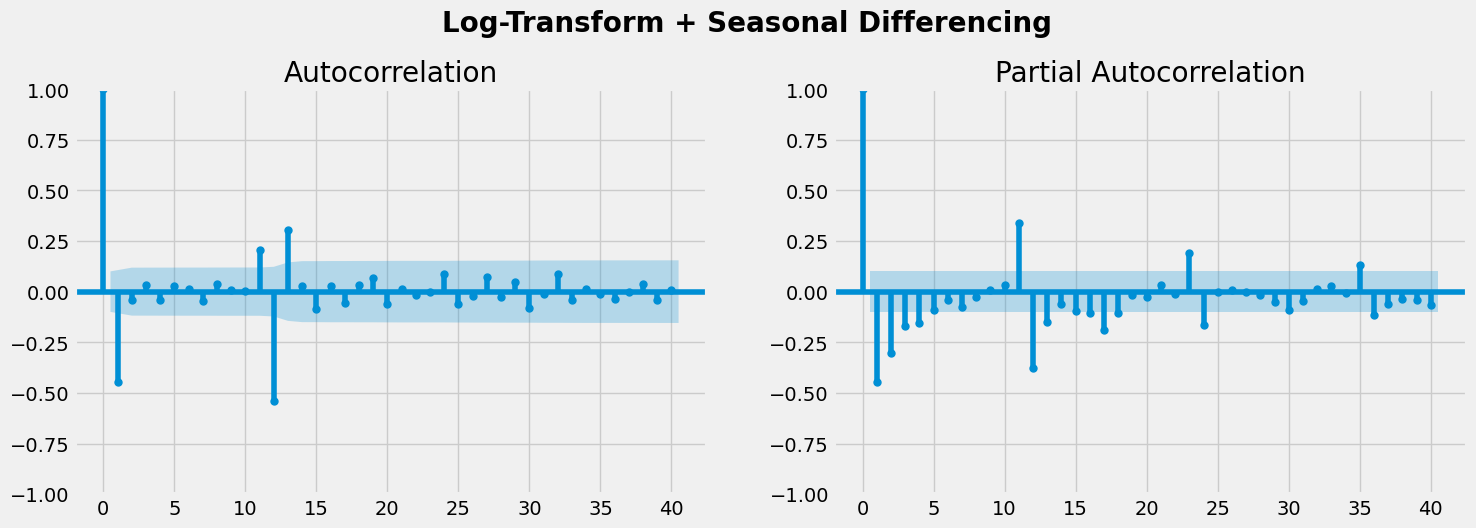

In [20]:
df["water_log_diff1_seasonal"] = df["water_log_diff1"].diff(12).dropna()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['water_log_diff1_seasonal'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['water_log_diff1_seasonal'].dropna(), lags=40, ax=ax[1])
plt.suptitle("Log-Transform + Seasonal Differencing", fontsize=20, fontweight="bold", y=1.04)
plt.show()

- Seasonal differencing makes Lag 12 even more prominent, even getting Lag 1 to emerge.

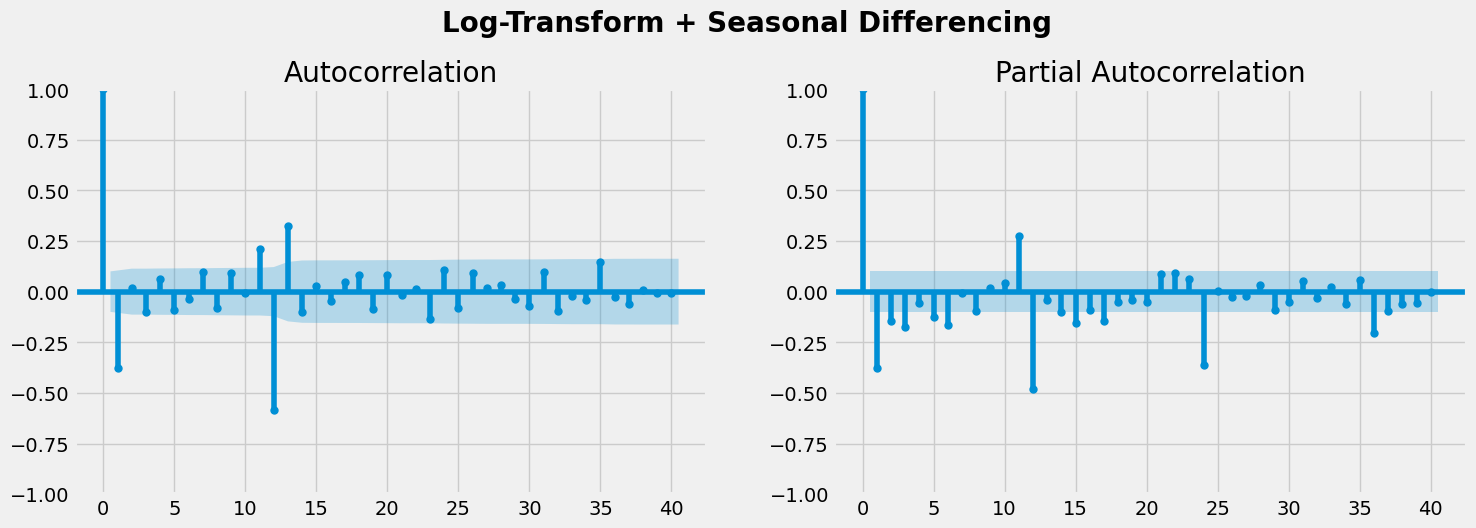

In [21]:
df["gas_bc_diff1_seasonal"] = df["gas_bc_diff1"].diff(12).dropna()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['gas_bc_diff1_seasonal'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['gas_bc_diff1_seasonal'].dropna(), lags=40, ax=ax[1])
plt.suptitle("Log-Transform + Seasonal Differencing", fontsize=20, fontweight="bold", y=1.04)
plt.show()

- Seasonal differencing makes Lag 12 and 13 worse.

---

### **Auto-ARIMA for `electricity_mwh_log`**
Why Auto-ARIMA? It provides a quick and easy way to sanity-check my interpretations and findings above. **Auto ARIMA will NOT be used for my final model fitting**.  
Find the ARIMA with the lowest AIC (Akaike Information Criterion): “How good is the fit while penalising complexity?”  
AIC was only compared within the same dataset to ensure results are valid.

In [22]:
# model = auto_arima(
#   df['electricity_mwh_log'].dropna(), 
#   seasonal=True, m=12, # monthly seasonality
#   trace=True
# )

To prevent long runtimes, I have screenshotted the results below:  
![Auto-ARIMA output](auto-ARIMA-results.png)  

**Auto-ARIMA found:**
```
Best model:  ARIMA(2,1,5)(1,0,2)[12]          
Total fit time: 131.152 seconds
```

➙ p = 2  
➙ d = 1 (ignore, as I already have a differenced electricity column in my df)  
➙ q = 5  
➙ Seasonal AR(1), MA(2), ___no seasonal differencing___, season length of 12  

Most of Auto-ARIMA's results align with ours, except the lack of seasonal differencing is strange. We will try comparing ARIMA and SARIMA in the subsequent Modelling section.

### Train / Validation / Test Split
The dataset was split chronologically into training, validation and testing sets to prevent data leakage and reflect real-world forecasting conditions.

In [23]:
train_end = "2016-12-01"
val_end = "2018-12-01"

train = df.loc[:train_end]
val = df.loc[train_end:val_end].iloc[1:]
test = df.loc[val_end:].iloc[1:]

# electricity
train_electricity = train["electricity_mwh_log"]
val_electricity = val["electricity_mwh_log"]
test_electricity = test["electricity_mwh_log"]

# water
train_water = train["water_tons_log"]
val_water = val["water_tons_log"]
test_water = test["water_tons_log"]

# gas
train_gas = train["gas_tons_bc"]
val_gas = val["gas_tons_bc"]
test_gas = test["gas_tons_bc"]

---

## **STAGE 3: Modelling & Evaluation**

Evaluating SARIMA Parameters
- **P > |z|** → Significant if < 0.05, else candidate for removal
- **|z| ≥ 2** → Significant
- Check if 0 lies inside the 95% confidence interval → Significant if not inside

---

### **Electricity Consumption (MWh)**

#### Experiment Best SARIMA
Use only Train dataset to decide best parameters

In [24]:
models = {
  'SARIMA_215_102': (2, 1, 5, 1, 0, 2, 12),  # Suggested by Auto ARIMA
  'SARIMA_111_111': (1, 1, 1, 1, 1, 1, 12),  # Add seasonal MA
  'SARIMA_011_011': (0, 1, 1, 0, 1, 1, 12),  # Pure MA approach
  'SARIMA_110_111': (1, 1, 0, 1, 1, 1, 12),  # No non-seasonal MA
  'SARIMA_211_111': (2, 1, 1, 1, 1, 1, 12),  # More AR terms
  'SARIMA_112_111': (1, 1, 2, 1, 1, 1, 12)   # More MA terms
}

results = []

for name, (p, d, q, P, D, Q, s) in models.items():
  # fit model
  model = SARIMAX(
    train_electricity,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
  )

  fitted = model.fit(disp=False)

  # calculate evaluation metrics
  forecast = fitted.get_forecast(steps=len(val_electricity))
  y_pred = forecast.predicted_mean
  rmse = np.sqrt(mean_squared_error(val_electricity, y_pred))
  mae = mean_absolute_error(val_electricity, y_pred)
  mape = mean_absolute_percentage_error(val_electricity, y_pred) * 100

  # Ljung-Box test
  lb_test = acorr_ljungbox(fitted.resid.dropna(), lags=[12], return_df=True)
  lb_pval = lb_test.loc[12, 'lb_pvalue']

  results.append({
    'Model': name,
    'Order': f'({p},{d},{q})({P},{D},{Q},{s})',
    'AIC': fitted.aic,
    'BIC': fitted.bic,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape,
    'Ljung-Box p-value': lb_pval
  })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['MAPE (%)', 'AIC']).reset_index(drop=True)
results_df

Model              Order          AIC          BIC      RMSE  \
0  SARIMA_011_011  (0,1,1)(0,1,1,12) -1339.545423 -1328.464227  0.024920   
1  SARIMA_110_111  (1,1,0)(1,1,1,12) -1329.371387 -1314.583013  0.025621   
2  SARIMA_215_102  (2,1,5)(1,0,2,12) -1335.321924 -1294.840026  0.029733   
3  SARIMA_112_111  (1,1,2)(1,1,1,12) -1365.255828 -1343.113671  0.029958   
4  SARIMA_211_111  (2,1,1)(1,1,1,12) -1371.360452 -1349.198060  0.030054   
5  SARIMA_111_111  (1,1,1)(1,1,1,12) -1370.676987 -1352.208326  0.029997   

        MAE  MAPE (%)  Ljung-Box p-value  
0  0.019656  0.284145       2.101556e-10  
1  0.020690  0.299230       8.447681e-11  
2  0.024421  0.352865       1.203384e-21  
3  0.025174  0.363786       3.764737e-12  
4  0.025268  0.365141       1.374603e-13  
5  0.025363  0.366499       1.411408e-13

* SARIMA_011_011 beats all the models in terms of RMSE, MAE and MAPE while slightly compromising on AIC (~-1340 compared to the lowest AIC of ~-1371)

* SARIMA_110_111 is close behind.  

* Auto-ARIMA's suggestion (SARIMA_215_102) scored one of the lowest AIC scores but heavily compromised on RMSE, MAE and MAPE.

→ **I will re-fit SARIMA_011_011 on the train+validation set, then evaluate its final performance on the test set.**

#### Fit Best Model (SARIMA_011_011)
Combine Train + Validation set

Best model from validation: SARIMA_011_011
                                     SARIMAX Results                                      
Dep. Variable:                electricity_mwh_log   No. Observations:                  348
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 726.270
Date:                            Sun, 08 Feb 2026   AIC                          -1446.540
Time:                                    20:46:13   BIC                          -1435.226
Sample:                                01-01-1990   HQIC                         -1442.023
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4059      0.054     -7.450      0.000      -0.513     

lb_stat     lb_pvalue
12  75.969168  2.408743e-11
24  75.997738  2.606850e-07

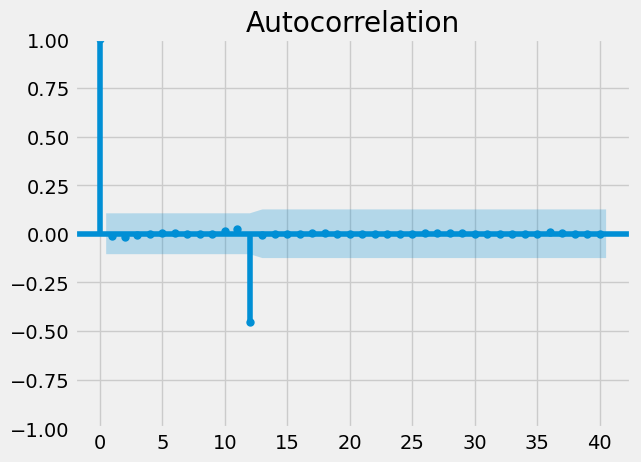

In [25]:
# get best model and params
best_model_name = results_df.iloc[0]['Model']
best_params = models[best_model_name]
print(f"Best model from validation: {best_model_name}")

# join train and validation set for re-fitting
train_val = pd.concat([train_electricity, val_electricity])
p, d, q, P, D, Q, s = best_params

SARIMA_011_011 = SARIMAX(
  train_val,
  order=(p, d, q),
  seasonal_order=(P, D, Q, s),
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_011_011 = SARIMA_011_011.fit(disp=False)

print(fit_011_011.summary())
plot_acf(fit_011_011.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_011_011.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

**Interpreting the Results**

SARIMA Results Summary

P > |z|
- All coefficients are < 0.05 → important, keep

Residual ACF Plot
- Most lags close to zero
- Differencing proves to be effective as there are no slow decays and no obvious seasonal patterns (like in the ACF plot before applying seasonal differencing)
- Large negative spike at lag 12 suggests that there is **remaining seasonal autocorrelation at 12 months** that the model did not fully absorb. The model is **not fully specified**.

Ljung-Box test
- Lag 12 p-value way below 0.05
- Lag 24 p-value much closer but still way below 0.05

→ **Conclusion: Try adding more seasonal MA terms to account for the seasonality.**

#### Fit Improved SARIMA (011_013)

                                         SARIMAX Results                                          
Dep. Variable:                        electricity_mwh_log   No. Observations:                  348
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood                 672.003
Date:                                    Sun, 08 Feb 2026   AIC                          -1334.006
Time:                                            20:46:17   BIC                          -1315.538
Sample:                                        01-01-1990   HQIC                         -1326.613
                                             - 12-01-2018                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4098      0.059     -6.965      0

lb_stat     lb_pvalue
12  76.329026  2.058824e-11
24  76.370007  2.279488e-07

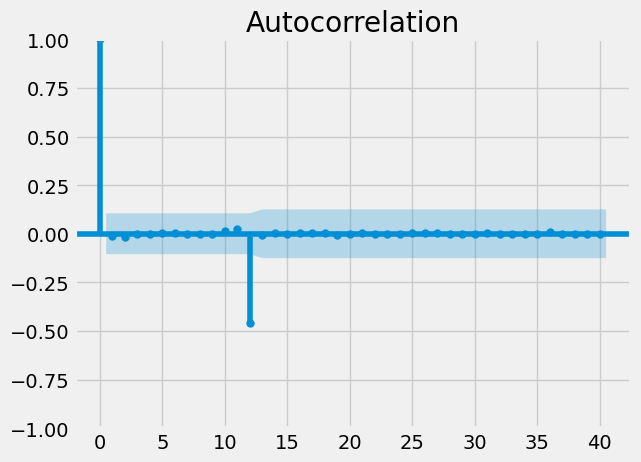

In [26]:
SARIMA_011_013 = SARIMAX(
  train_val,
  order=(0, 1, 1),
  seasonal_order=(0, 1, 3, 12), # updated Q from 1 to 3
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_011_013 = SARIMA_011_013.fit()

print(fit_011_013.summary())
plot_acf(fit_011_013.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_011_013.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

**New iteration helped simplify the model but did not solve seasonal autocorrelation**

SARIMA Results Summary
- Lag 36 is significant (z > 2, "P > |z|" < 0.05)
- Remaining coefficients are not as significant (z < 2, >"P > |z|" > 0.05)
- Additional Seasonal MA terms did not destabilise the model AND substantially improved the AIC metric (-1447 → -1334).

Ljung-Box test
- Lag 12 p-value is slightly closer to 0.05

→ **Conclusion: Try adding more non-seasonal MA terms.**

#### Fit Improved SARIMA (013_013)

                                     SARIMAX Results                                      
Dep. Variable:                electricity_mwh_log   No. Observations:                  348
Model:             SARIMAX(0, 1, 3)x(0, 1, 3, 12)   Log Likelihood                 684.480
Date:                            Sun, 08 Feb 2026   AIC                          -1354.960
Time:                                    20:46:24   BIC                          -1329.151
Sample:                                01-01-1990   HQIC                         -1344.626
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3980      0.062     -6.422      0.000      -0.519      -0.277
ma.L2         -0.3175      0.061   

lb_stat     lb_pvalue
12  76.391301  2.003629e-11
24  76.432543  2.228625e-07

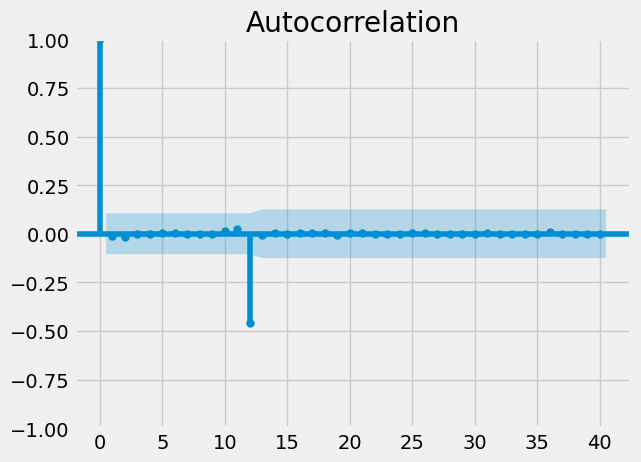

In [27]:
SARIMA_013_013 = SARIMAX(
  train_val,
  order=(0, 1, 3), # updated q from 1 to 3
  seasonal_order=(0, 1, 3, 12),
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_013_013 = SARIMA_013_013.fit()

print(fit_013_013.summary())
plot_acf(fit_013_013.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_013_013.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

#### Compare Evaluation Metrics: ***RMSE***, ***MAE***, ***AIC***, ***LB p-value***

In [28]:
# attempted improving these SARIMAs
models_best = {
  'SARIMA_011_011': fit_011_011,
  'SARIMA_011_013': fit_011_013,
  'SARIMA_013_013': fit_013_013
}

# re-fit on train+validation set, forecast on train_val and calculate evaluation metrics for comparison
for model_name, model_fit in models_best.items():
  test_forecast = model_fit.get_forecast(steps=len(train_val))
  test_pred = test_forecast.predicted_mean

  test_rmse = np.sqrt(mean_squared_error(train_val, test_pred))
  test_mae = mean_absolute_error(train_val, test_pred)
  test_mape = mean_absolute_percentage_error(train_val, test_pred) * 100

  print(f"{model_name}")
  print(f"Test RMSE: {test_rmse:.4f}")
  print(f"Test MAE: {test_mae:.4f}")
  print(f"Test MAPE: {test_mape:.2f}%\n")

SARIMA_011_011
Test RMSE: 0.3794
Test MAE: 0.3726
Test MAPE: 5.55%

SARIMA_011_013
Test RMSE: 0.3549
Test MAE: 0.3453
Test MAPE: 5.14%

SARIMA_013_013
Test RMSE: 0.2841
Test MAE: 0.2593
Test MAPE: 3.88%



**Experimented SARIMA Models (Electricity Consumption)**  
| SARIMA Model | Ljung-Box p-value | Test RMSE | Test MAE | Test MAPE | AIC |
|--------------|:--------------------------:|:---------:|:--------:|:--------:|:-----:|
| SARIMA(0,1,1)(0,1,1,12) | 2.41e-11 | 0.3794 | 0.3726 | 5.55% | – |
| SARIMA(0,1,1)(0,1,3,12) | 2.06e-11 | 0.3549 | 0.3453 | 5.14% | – |
| SARIMA(0,1,3)(0,1,3,12) | 2.00e-11 | 0.2841 | 0.2593 | 3.88% | – |

_Note: Ljung-Box p-value reading is at Lag 12._

**Selected Model: SARIMA(0,1,3)(0,1,3,12)**

**Justification:**
- Achieved the **lowest Test RMSE** (0.2841)
- Achieved the **lowest Test MAE** (0.2593)
- Achieved the **lowest Test MAPE** (3.88%), meaning it produced the most accurate forecasts in percentage terms
- The increase in AR and MA terms helped the model better capture seasonal fluctuations and short-term dynamics

**Limitation:**  
Although forecast accuracy improved significantly, higher-order SARIMA models are more complex and may be harder to interpret. There may still be remaining autocorrelation or external factors (e.g., holidays or operational changes) that SARIMA alone cannot fully explain.

#### Visualise Best SARIMA's Forecast
Forecast on Test set

In [29]:
# forecast on test set
final_forecast = fit_013_013.get_forecast(steps=len(test_electricity))
test_pred = final_forecast.predicted_mean

# calculate evaluation metrics
test_rmse = np.sqrt(mean_squared_error(test_electricity, test_pred))
test_mae = mean_absolute_error(test_electricity, test_pred)
test_mape = mean_absolute_percentage_error(test_electricity, test_pred) * 100

print("SARIMA_013_013's Test Performance")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

SARIMA_013_013's Test Performance
RMSE: 0.0338
MAE : 0.0261
MAPE: 0.38%


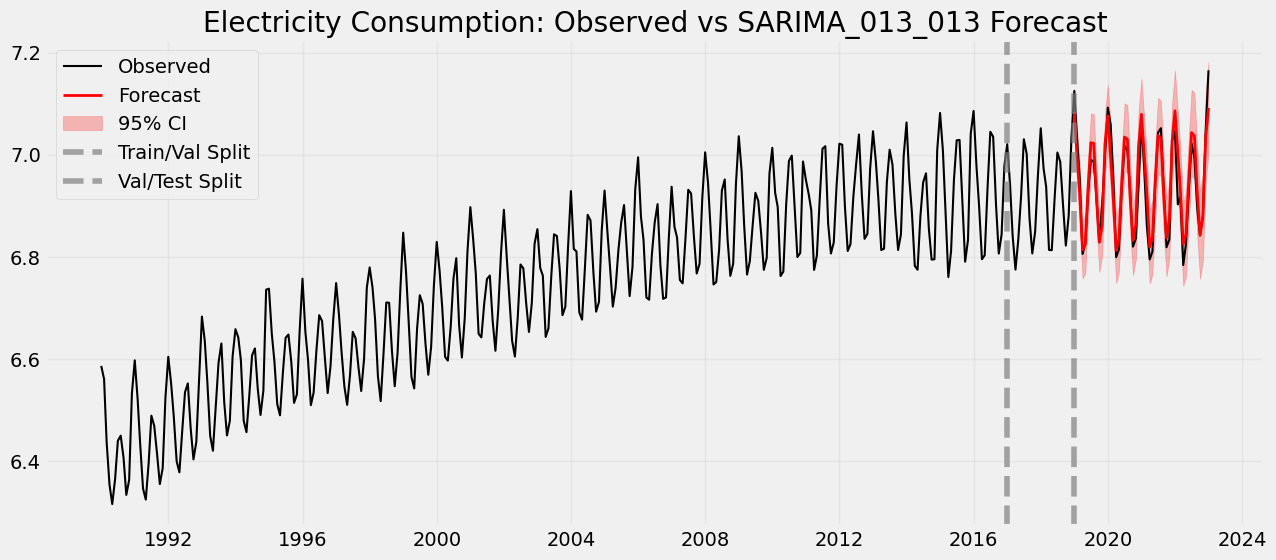

In [30]:
# get confidence interval
test_ci = final_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['electricity_mwh_log'], # original series
         label='Observed', color='black', linewidth=1.5)
plt.plot(test_electricity.index, test_pred, # test period/forecast
         label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_electricity.index,
  test_ci.iloc[:, 0],
  test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/validation/test split
plt.axvline(val_electricity.index[0], color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(test_electricity.index[0], color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title('Electricity Consumption: Observed vs SARIMA_013_013 Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The forecast turned out quite well!
- All actual data points fall within the 95% confidence interval → SARIMA_013_013's uncertainty estimates are reasonable
- Forecasted values (solid red line) closely track the test data → SARIMA_013_013 effectively captures both trend and seasonal patterns in electricity consumption.

→ **Conclusion: I can safely conclude that with a Test MAPE of ***0.38%***, SARIMA_013_013 performed extremely well!**

---

### **Water Consumption (tons)**

#### Experiment Best Prophet

In [31]:
models = {
  'Prophet_Default': 
  {
    'growth': 'linear',
    'seasonality_mode': 'additive',
    'yearly_seasonality': 'auto',    # default 
    'weekly_seasonality': 'auto',    # default
    'daily_seasonality': 'auto',     # default
    'changepoint_prior_scale': 0.05  # default
  },

  'Prophet_MultiplicativeSeasonal': 
  {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_prior_scale': 0.05
  },

  'Prophet_FlexibleTrend':
  {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_prior_scale': 0.5
  },

  'Prophet_LessFlexibleTrend': 
  {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_prior_scale': 0.01
  },
}


#### Prepare Data for Prophet

In [32]:
# prepare data for Prophet (requires 'ds' and 'y' columns)
def prepare_prophet_data(series):
  """Convert time series (Series) to Prophet format"""
  prophet_df = pd.DataFrame({
    'ds': series.index,
    'y': series.values
  })
  return prophet_df

# Prepare non-logged split
train_water_raw = df.loc[:train_end]["water_tons"]
val_water_raw = df.loc[train_end:val_end].iloc[1:]["water_tons"]
test_water_raw = df.loc[val_end:].iloc[1:]["water_tons"]

# Prophet train and test data
train_prophet = prepare_prophet_data(train_water_raw)
val_prophet = prepare_prophet_data(val_water_raw)
test_prophet = prepare_prophet_data(test_water_raw)

In [33]:
results = []
fitted_models = {}

for model_name, params in models.items():
  # fit model
  model = Prophet(**params)
  model.fit(train_prophet)

  # forecast on validation set
  future = model.make_future_dataframe(periods=len(val_prophet), freq='MS')
  forecast = model.predict(future)
  val_pred = forecast.iloc[-len(val_prophet):]['yhat'].values

  # calculate evaluation metrics
  rmse = np.sqrt(mean_squared_error(val_prophet['y'], val_pred))
  mae = mean_absolute_error(val_prophet['y'], val_pred)
  mape = mean_absolute_percentage_error(val_prophet['y'], val_pred) * 100

  results.append({
    'Model': model_name,
    'Growth': params['growth'],
    'Seasonality': params['seasonality_mode'],
    'Changepoint_Prior': params['changepoint_prior_scale'],
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
  })

  fitted_models[model_name] = {
    'model': model,
    'forecast': forecast
  }

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['MAPE (%)', 'RMSE']).reset_index(drop=True)
results_df

20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] done processing
20:46:26 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing


Model  Growth     Seasonality  Changepoint_Prior  \
0           Prophet_FlexibleTrend  linear  multiplicative               0.50   
1       Prophet_LessFlexibleTrend  linear  multiplicative               0.01   
2                 Prophet_Default  linear        additive               0.05   
3  Prophet_MultiplicativeSeasonal  linear  multiplicative               0.05   

         RMSE         MAE   MAPE (%)  
0  106.973438   76.554829  21.039975  
1  126.527261   95.976125  26.153433  
2  182.099228  158.484874  40.473930  
3  182.056512  159.392995  40.477062

In [34]:
# get best model and params
best_model_name = results_df.iloc[0]['Model']
best_params = models[best_model_name]
print(f"Best model from validation: {best_model_name}")

# join train and validation set for re-fitting
train_val = pd.concat([train_water_raw, val_water_raw])
train_val_prophet = prepare_prophet_data(train_val)

# fit on combined train+val
best_model = Prophet(**best_params)
best_model.fit(train_val_prophet)

# forecast on test set
future = best_model.make_future_dataframe(periods=len(test_prophet), freq='MS')
best_forecast = best_model.predict(future)

# Ljung-Box test on train+val residuals
train_val_forecast_values = best_forecast.iloc[:len(train_val_prophet)]['yhat'].values
train_val_residuals = train_val_prophet['y'].values - train_val_forecast_values
lb_result = acorr_ljungbox(train_val_residuals, lags=[12, 24], return_df=True)

print("\nLjung-Box Test Results:")
lb_result

20:46:26 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing


Best model from validation: Prophet_FlexibleTrend

Ljung-Box Test Results:


lb_stat     lb_pvalue
12  102.924464  1.485685e-16
24  169.153185  8.454814e-24

In [35]:
# extract test predictions
test_pred = best_forecast.iloc[-len(test_prophet):]['yhat'].values
test_ci_lower = best_forecast.iloc[-len(test_prophet):]['yhat_lower'].values
test_ci_upper = best_forecast.iloc[-len(test_prophet):]['yhat_upper'].values

# calculate test metrics
test_rmse = np.sqrt(mean_squared_error(test_prophet['y'], test_pred))
test_mae = mean_absolute_error(test_prophet['y'], test_pred)
test_mape = mean_absolute_percentage_error(test_prophet['y'], test_pred) * 100

print(f"\n{best_model_name}'s Test Performance")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")


Prophet_FlexibleTrend's Test Performance
RMSE: 118.9220
MAE : 91.4606
MAPE: 19.23%


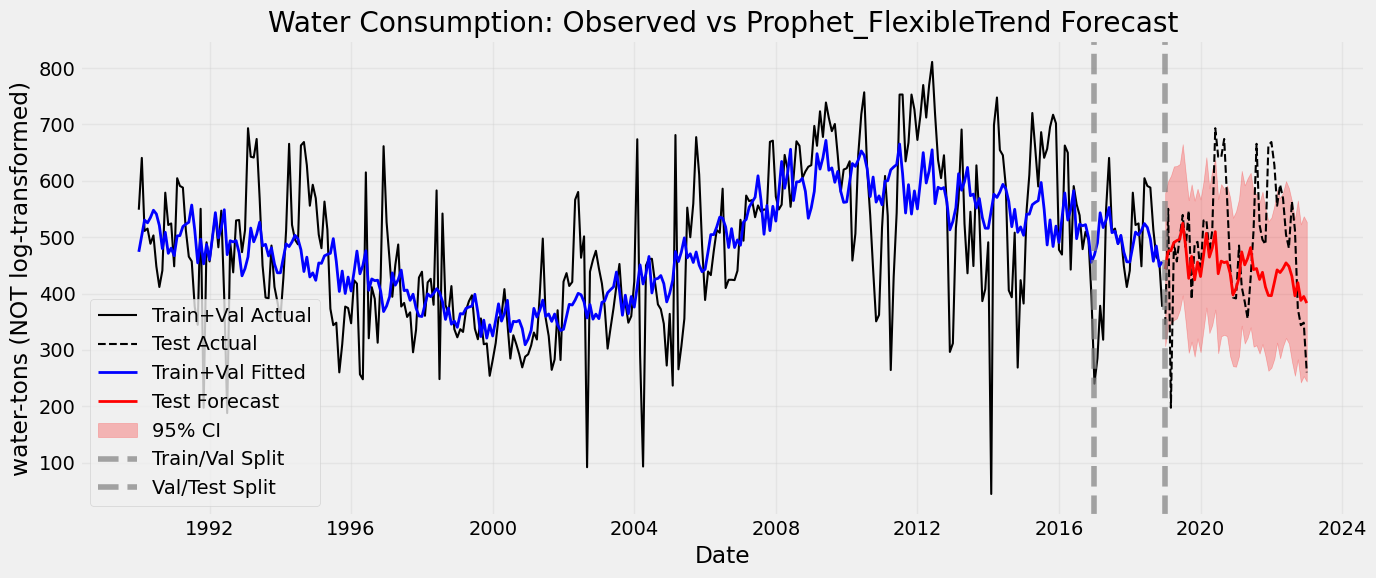

In [36]:
# get train+val fitted values
train_val_forecast = best_forecast.iloc[:len(train_val_prophet)]['yhat']

plt.figure(figsize=(14, 6))

# plot train+val, test+val, forecast on test + test
plt.plot(train_val_prophet['ds'], train_val_prophet['y'], 
         label="Train+Val Actual", color="black", linewidth=1.5)
plt.plot(test_prophet['ds'], test_prophet['y'], 
         label="Test Actual", color="black", linewidth=1.5, linestyle="--")
plt.plot(train_val_prophet['ds'], train_val_forecast, 
         label="Train+Val Fitted", color="blue", linewidth=2)
plt.plot(test_prophet['ds'], test_pred, 
         label="Test Forecast", color="red", linewidth=2)

# confidence interval
plt.fill_between(
  test_prophet['ds'],
  test_ci_lower, test_ci_upper,
  color='red', alpha=0.25, label='95% CI'
)

# mark train/validation/test split
plt.axvline(val_water_raw.index[0], color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(test_water_raw.index[0], color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title(f"Water Consumption: Observed vs {best_model_name} Forecast")
plt.xlabel("Date")
plt.ylabel("water-tons (NOT log-transformed)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Analyze Best Prophet Using Built-in `.plot()` and `.plot_components()`
Understanding our best Prophet model more in-depth.

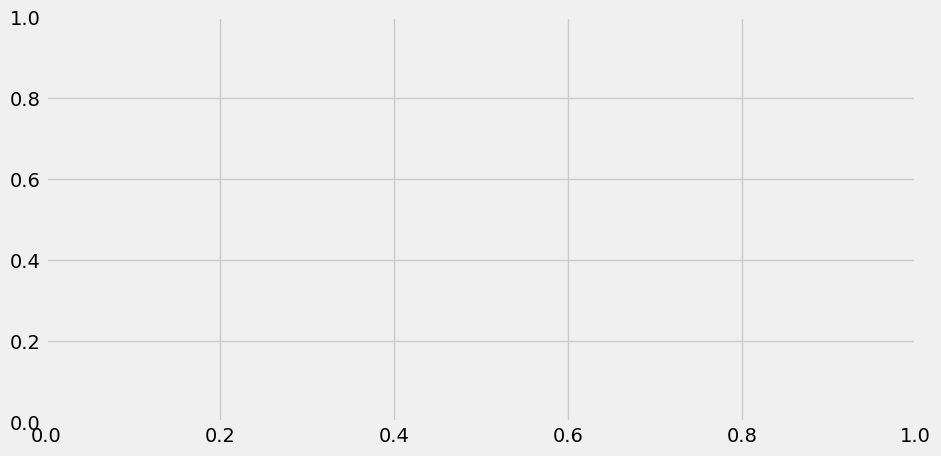

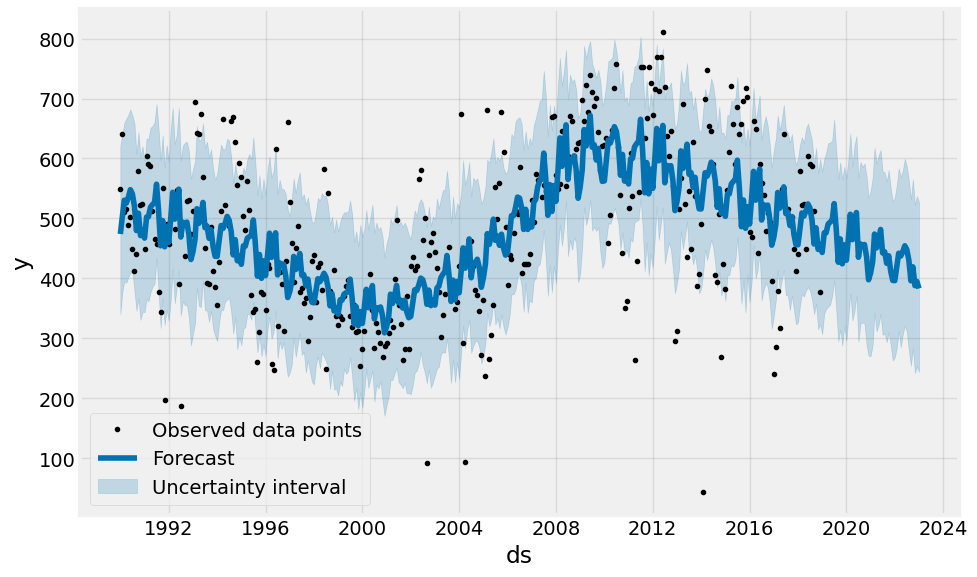

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = best_model.plot(best_forecast)
plt.legend()
plt.show()

- Prophet_FlexibleTrend was able to accurately capture most of the non-anomalous data points inside its uncertainty interval. It captures the trend and seasonality extremely well, though it compromises on amplitude/magnitude which causes its MAPE to skyrocket to 19%. Thus, I can justify this high MAPE.

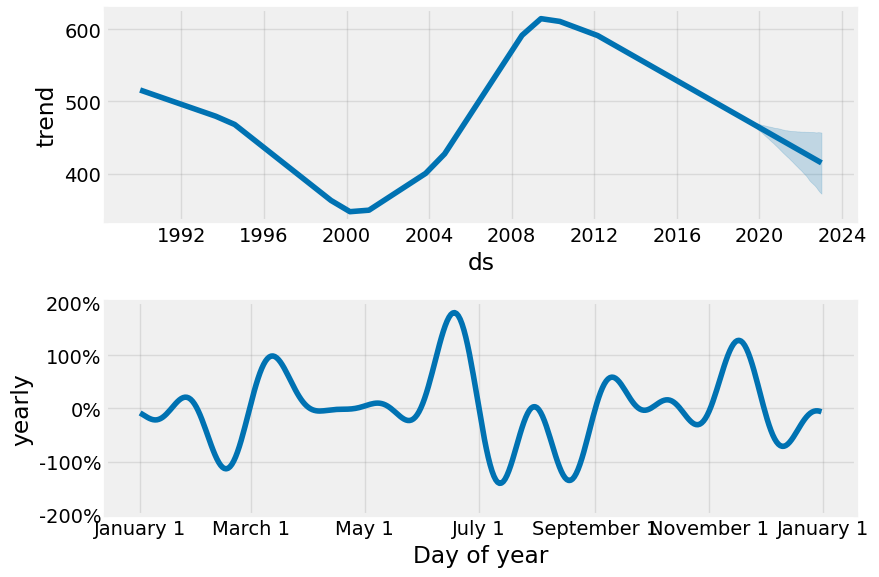

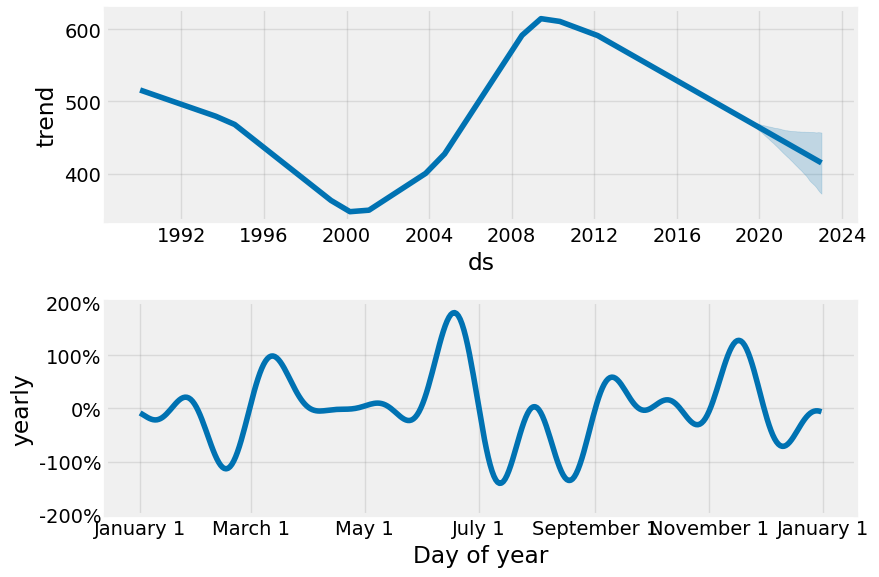

In [38]:
best_model.plot_components(best_forecast)

#### Visualise Best Prophet

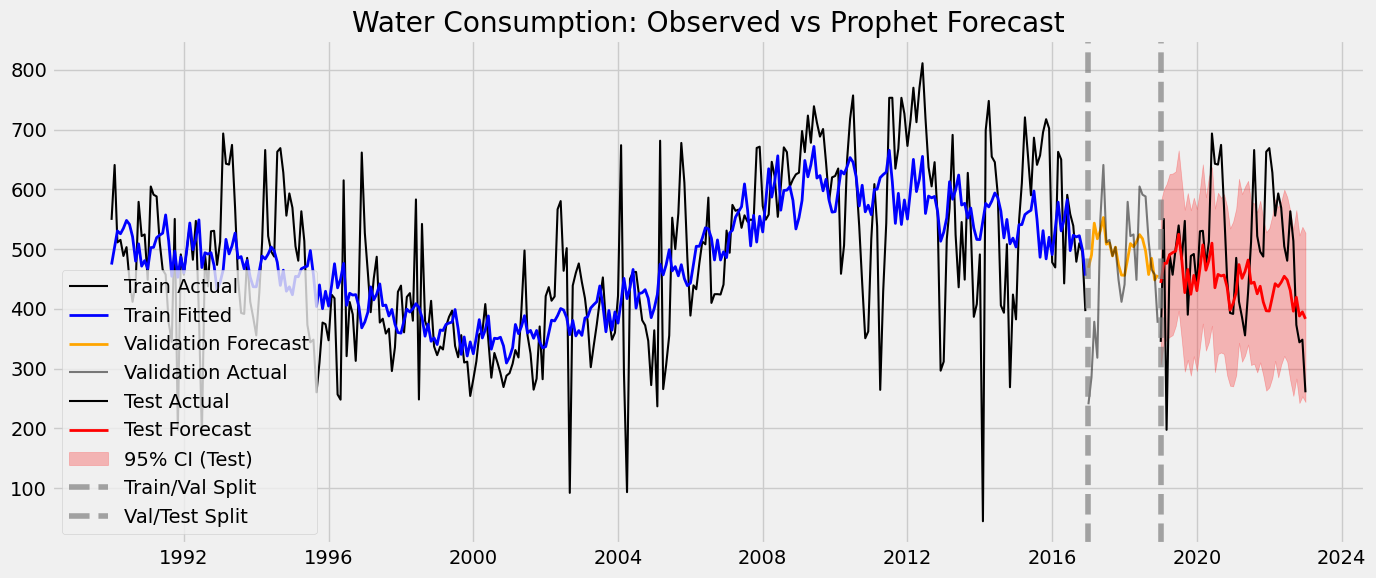

In [39]:
# get train, validation, test forecasts
train_forecast = best_forecast.iloc[:len(train_prophet)]['yhat']
val_forecast   = best_forecast.iloc[len(train_prophet):len(train_prophet)+len(val_prophet)]['yhat']
test_forecast  = best_forecast.iloc[len(train_prophet)+len(val_prophet):]['yhat']

# get confidence intervals for test
test_forecast_lower = best_forecast.iloc[len(train_prophet)+len(val_prophet):]['yhat_lower']
test_forecast_upper = best_forecast.iloc[len(train_prophet)+len(val_prophet):]['yhat_upper']

plt.figure(figsize=(14, 6))

# plot training set (actual + forecast)
plt.plot(train_prophet['ds'], train_prophet['y'], label="Train Actual", color="black", linewidth=1.5)
plt.plot(train_prophet['ds'], train_forecast, label="Train Fitted", color="blue", linewidth=2)

# plot validation set (actual + forecast)
plt.plot(val_prophet['ds'], val_forecast, label="Validation Forecast", color="orange", linewidth=2)
plt.plot(val_prophet['ds'], val_prophet['y'], label="Validation Actual", color="black", linewidth=1.5, alpha=0.5)

# plot test set (actual + forecast)
plt.plot(test_prophet['ds'], test_prophet['y'], label="Test Actual", color="black", linewidth=1.5)
plt.plot(test_prophet['ds'], test_forecast, label="Test Forecast", color="red", linewidth=2)

# plot confidence interval
plt.fill_between(
  test_prophet['ds'],
  test_forecast_lower, test_forecast_upper,
  color='red', alpha=0.25, label='95% CI (Test)'
)

# mark train/validation/test split
plt.axvline(val_prophet['ds'].iloc[0], color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(test_prophet['ds'].iloc[0], color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title("Water Consumption: Observed vs Prophet Forecast")
plt.legend()
plt.tight_layout()
plt.show()


#### Experiment Best SARIMA

In [40]:
models = {
  'SARIMA_111_000': (1, 1, 1, 0, 0, 0, 12),  # Interpreted from ACF PACF plots
  'SARIMA_101_110': (1, 0, 1, 1, 1, 0, 12),  # Try pure seasonal differencing
  'SARIMA_111_111': (1, 1, 1, 1, 1, 1, 12),  # Try adding seasonal terms
  'SARIMA_011_011': (0, 1, 1, 0, 1, 1, 12),  # Pure MA approach
  'SARIMA_110_110': (1, 1, 0, 1, 1, 0, 12),  # Pure AR approach
  'SARIMA_112_111': (1, 1, 2, 1, 1, 1, 12),  # More MA terms
  'SARIMA_121_000': (1, 2, 1, 1, 1, 1, 12)   # Try Second-Differencing
}

results = []

for name, (p, d, q, P, D, Q, s) in models.items():
  # fit model
  model = SARIMAX(
    train_water,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
  )

  fitted = model.fit(disp=False)

  # calculate evaluation metrics
  forecast = fitted.get_forecast(steps=len(val_water))
  y_pred = forecast.predicted_mean
  rmse = np.sqrt(mean_squared_error(val_water, y_pred))
  mae = mean_absolute_error(val_water, y_pred)
  mape = mean_absolute_percentage_error(val_water, y_pred) * 100

  results.append({
    'Model': name,
    'Order': f'({p},{d},{q})({P},{D},{Q},{s})',
    'AIC': fitted.aic,
    'BIC': fitted.bic,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
  })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['MAPE (%)', 'AIC']).reset_index(drop=True)
results_df

Model              Order         AIC         BIC      RMSE  \
0  SARIMA_121_000  (1,2,1)(1,1,1,12)  239.339663  257.791460  0.213991   
1  SARIMA_011_011  (0,1,1)(0,1,1,12)  153.037190  164.118386  0.233003   
2  SARIMA_111_000  (1,1,1)(0,0,0,12)  123.065799  134.380122  0.260016   
3  SARIMA_111_111  (1,1,1)(1,1,1,12)  160.608998  179.077659  0.249895   
4  SARIMA_112_111  (1,1,2)(1,1,1,12)  162.370655  184.512812  0.250014   
5  SARIMA_110_110  (1,1,0)(1,1,0,12)  286.553723  297.645003  0.250311   
6  SARIMA_101_110  (1,0,1)(1,1,0,12)  209.136570  223.938344  0.273982   

        MAE  MAPE (%)  
0  0.144983  2.423271  
1  0.157818  2.666440  
2  0.181575  3.072896  
3  0.184257  3.099384  
4  0.184387  3.101828  
5  0.191619  3.174191  
6  0.202820  3.407338

* SRARIMA_121_000 beats all the models in terms of RMSE, MAE and MAPE while heavily compromising on AIC (~257.8 compared to the 1st runner-up, SARIMA_011_011, whose MAPE is only 0.24% higher than SARIMA_121_000 but yields the lowest AIC of ~153).

→ **I will re-fit SARIMA_011_011 on the train+validation set, then evaluate its final performance on the test set.**

#### Fit Best Model (SARIMA_011_011)
Combine Train + Validation set

Best model from validation: SARIMA_011_011
                                     SARIMAX Results                                      
Dep. Variable:                     water_tons_log   No. Observations:                  324
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -73.519
Date:                            Sun, 08 Feb 2026   AIC                            153.037
Time:                                    20:46:30   BIC                            164.118
Sample:                                01-01-1990   HQIC                           157.473
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8236      0.025    -32.325      0.000      -0.874     

lb_stat  lb_pvalue
12  40.718125   0.000055
24  48.275625   0.002333

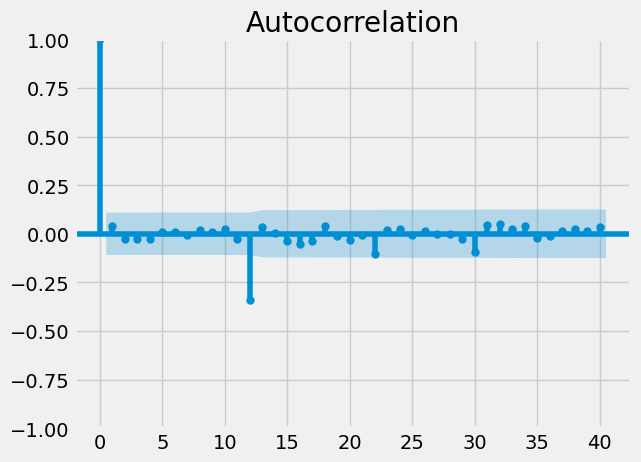

In [41]:
# get best model and params
best_model_name = results_df.iloc[1]['Model'] # use SARIMA_011_011
best_params = models[best_model_name]
print(f"Best model from validation: {best_model_name}")

# join train and validation set for re-fitting
train_val = pd.concat([train_water, val_water])
p, d, q, P, D, Q, s = best_params

SARIMA_011_011 = SARIMAX(
  train_water,
  order=(p, d, q),
  seasonal_order=(P, D, Q, s),
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_011_011 = SARIMA_011_011.fit()

print(fit_011_011.summary())
plot_acf(fit_011_011.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_011_011.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

#### Visualise Best SARIMA's Forecast
Forecast on Test set

In [42]:
final_forecast = fit_011_011.get_forecast(steps=len(test_water))
test_pred = final_forecast.predicted_mean

test_rmse = np.sqrt(mean_squared_error(test_water, test_pred))
test_mae = mean_absolute_error(test_water, test_pred)
test_mape = mean_absolute_percentage_error(test_water, test_pred) * 100

print("SARIMA_011_011's Test Performance")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

SARIMA_011_011's Test Performance
RMSE: 0.2666
MAE : 0.1970
MAPE: 3.27%


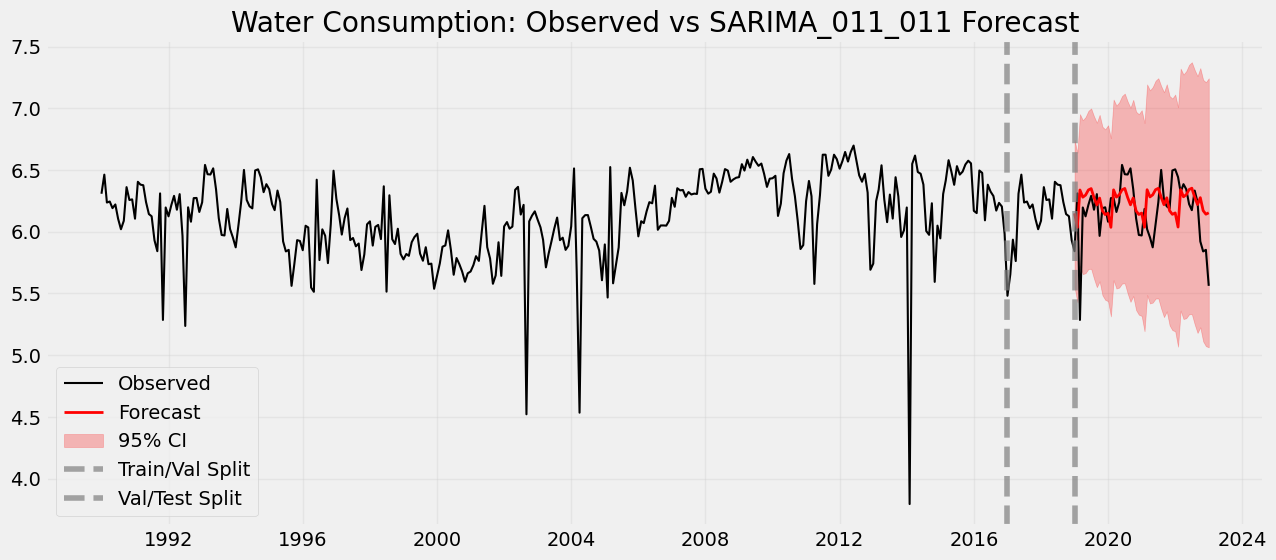

In [43]:
# forecast on test set
test_ci = final_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['water_tons_log'], # original series
         label='Observed', color='black', linewidth=1.5)
plt.plot(test_water.index, test_pred, # test period/forecast
         label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_water.index,
  test_ci.iloc[:, 0],
  test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/validation/test split
plt.axvline(val_water.index[0], color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(test_water.index[0], color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title('Water Consumption: Observed vs SARIMA_011_011 Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

### **Gas Consumption (tons)**

#### Experiment Best ARIMA
Use only Train dataset to decide best parameters

In [44]:
models = {
  'ARIMA_101': (1, 0, 1), # balanced p and q
  'ARIMA_111': (1, 1, 1), # try first-differencing
  'ARIMA_001': (0, 0, 1), # remove AR component
  'ARIMA_100': (1, 0, 0), # remove MA component
  'ARIMA_201': (2, 0, 1), # add more AR components
  'ARIMA_102': (1, 0, 2)  # add more MA components
}

results = []

for model_name, (p, d, q) in models.items():
  # fit model
  model = ARIMA(
    train_gas,
    order=(p, d, q),
    trend="t"
  )

  fitted = model.fit()
  
  # calculate evaluation metrics
  forecast = fitted.get_forecast(steps=len(val_gas))
  y_pred = forecast.predicted_mean
  rmse = np.sqrt(mean_squared_error(val_gas, y_pred))
  mae = mean_absolute_error(val_gas, y_pred)
  mape = mean_absolute_percentage_error(val_gas, y_pred) * 100
  
  # Ljung-Box test
  lb_test = acorr_ljungbox(fitted.resid.dropna(), lags=[12], return_df=True)
  lb_pval = lb_test.loc[12, 'lb_pvalue']
  
  results.append({
    'Model': model_name,
    'Order': (p, d, q),
    'AIC': fitted.aic,
    'BIC': fitted.bic,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape,
    'Ljung-Box p-value': lb_pval
  })
      
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['MAPE (%)', 'AIC']).reset_index(drop=True)
results_df

Model      Order          AIC          BIC      RMSE       MAE  \
0  ARIMA_100  (1, 0, 0)  1379.197976  1390.540206  2.285711  1.998966   
1  ARIMA_201  (2, 0, 1)  1309.665601  1328.569318  3.626788  3.308616   
2  ARIMA_111  (1, 1, 1)  1299.940980  1315.051590  3.627649  3.309891   
3  ARIMA_102  (1, 0, 2)  1319.375504  1338.279221  4.115413  3.806971   
4  ARIMA_101  (1, 0, 1)  1330.644240  1345.767215  4.364639  4.047567   
5  ARIMA_001  (0, 0, 1)  1908.255511  1919.597742  7.384022  7.046873   

    MAPE (%)  Ljung-Box p-value  
0  14.137077           0.000029  
1  22.993375           0.684752  
2  23.003618           0.687745  
3  26.502451           0.226502  
4  28.169525           0.180187  
5  53.752401           0.000000

* ARIMA_100 outperforms all the models in terms of RMSE, MAE and MAPE, though it lost by nearly 700units to ARIMA_001 in terms of AIC. This is a minor issue, ARIMA_100 still proves to be a far better choice than ARIMA_001 who has a MAPE of nearly 54%.

* No other models come close to ARIMA_100.  

→ **I will re-fit ARIMA_100 on the train+validation set, then evaluate its final performance on the test set.**

#### Fit Best Model (ARIMA_100)
Combine Train + Validation set

Best model from validation: ARIMA_100
                               SARIMAX Results                                
Dep. Variable:            gas_tons_bc   No. Observations:                  348
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -734.546
Date:                Sun, 08 Feb 2026   AIC                           1475.092
Time:                        20:46:31   BIC                           1486.648
Sample:                    01-01-1990   HQIC                          1479.693
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0545      0.011      4.808      0.000       0.032       0.077
ar.L1          0.9628      0.019     49.685      0.000       0.925       1.001
sigma2        

lb_stat  lb_pvalue
12  40.797491   0.000053
24  57.675279   0.000135

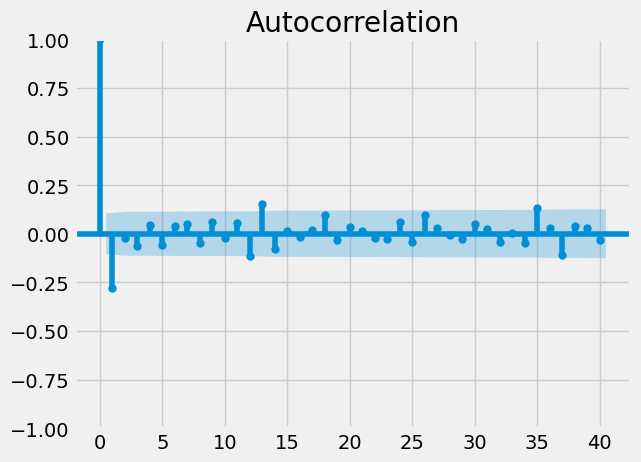

In [45]:
# get best model and params
best_model_name = results_df.iloc[0]['Model']
best_params = models[best_model_name]
print(f"Best model from validation: {best_model_name}")

# join train and validation set for re-fitting
train_val = pd.concat([train_gas, val_gas])
p, d, q = best_params

ARIMA_100 = ARIMA(
  train_val,
  order=(p, d, q),
  trend="t"
)

fit_100 = ARIMA_100.fit()

print(fit_100.summary())
plot_acf(fit_100.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_100.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

#### Visualise Best ARIMA's Forecast

In [46]:
final_forecast = fit_100.get_forecast(steps=len(test_gas))
test_pred = final_forecast.predicted_mean

test_rmse = np.sqrt(mean_squared_error(test_gas, test_pred))
test_mae = mean_absolute_error(test_gas, test_pred)
test_mape = mean_absolute_percentage_error(test_gas, test_pred) * 100

print("ARIMA_100's Test Performance")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

ARIMA_100's Test Performance
RMSE: 3.1326
MAE : 2.7257
MAPE: 18.30%


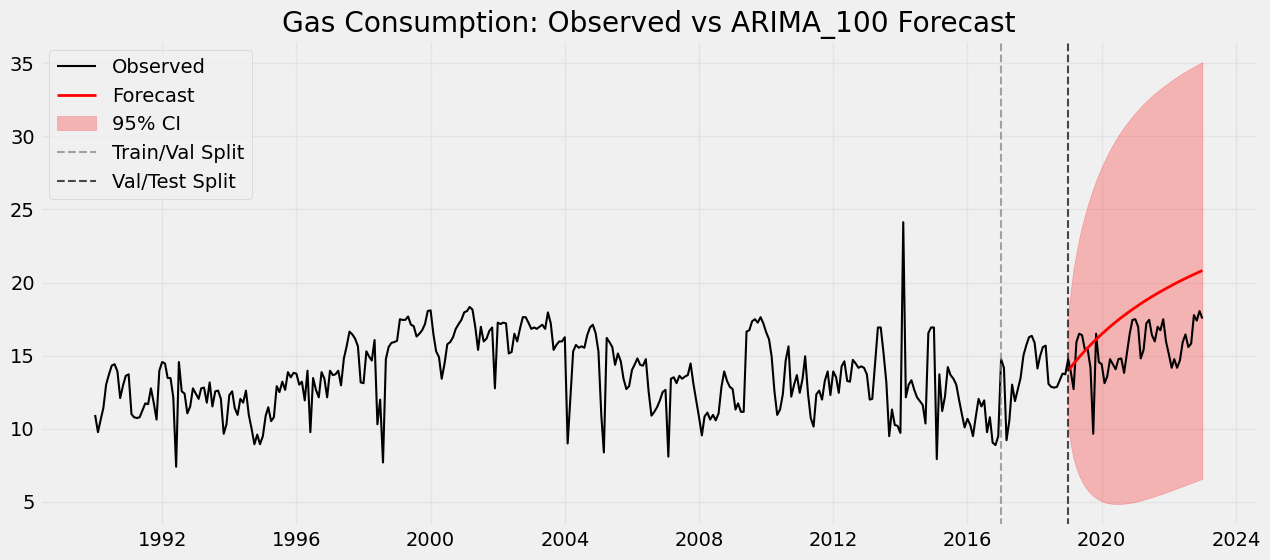

In [47]:
# get confidence interval
test_ci = final_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['gas_tons_bc'], label='Observed', color='black', linewidth=1.5)
plt.plot(test_gas.index, test_pred, label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_gas.index,
  test_ci.iloc[:, 0], test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/validation/test split
plt.axvline(val_gas.index[0], color='gray', linestyle='--', alpha=0.7, linewidth=1.5, label='Train/Val Split')
plt.axvline(test_gas.index[0], color='black', linestyle='--', alpha=0.7, linewidth=1.5, label='Val/Test Split')

plt.title('Gas Consumption: Observed vs ARIMA_100 Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


- ARIMA performed horribly, collapsing into a weird upward curve with decreasing trend that failed to capture the actual trend. 
- I will try Holt-Winters exponential smoothing.

#### Try Holt-Winters Exponential Smoothing

In [48]:
models = {
  'HW_add_add':  ('add', 'add'),  # additive trend, additive seasonality
  'HW_add_none': ('add', None),   # additive trend only
  'HW_none_add': (None, 'add'),   # additive seasonality only
  'HW_none_none':(None, None)     # simple exponential smoothing
}

results = []

for model_name, (trend, seasonal) in models.items():
  # fit model
  model = ExponentialSmoothing(
    train_gas,
    trend=trend,
    seasonal=seasonal,
    seasonal_periods=12 if seasonal else None
  )

  fitted = model.fit()
  
  # calculate evaluation metrics
  y_pred = fitted.forecast(len(val_gas))
  rmse = np.sqrt(mean_squared_error(val_gas, y_pred))
  mae = mean_absolute_error(val_gas, y_pred)
  mape = mean_absolute_percentage_error(val_gas, y_pred) * 100
  
  # Ljung-Box test
  lb_test = acorr_ljungbox(fitted.resid.dropna(), lags=[12], return_df=True)
  lb_pval = lb_test.loc[12, 'lb_pvalue']
  
  results.append({
    'Model': model_name,
    'Trend': trend,
    'Seasonal': seasonal,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape,
    'Ljung-Box p-value': lb_pval
  })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['RMSE']).reset_index(drop=True)
results_df

Model Trend Seasonal      RMSE       MAE   MAPE (%)  \
0  HW_none_none  None     None  4.665775  4.356125  30.372463   
1   HW_none_add  None      add  4.719178  4.407612  30.740305   
2   HW_add_none   add     None  4.722420  4.413190  30.779572   
3    HW_add_add   add      add  4.778480  4.468871  31.183194   

   Ljung-Box p-value  
0           0.008524  
1           0.005677  
2           0.008473  
3           0.005643

Best model from validation: HW_add_add


lb_stat  lb_pvalue
12  28.772849   0.004258
24  42.800632   0.010481

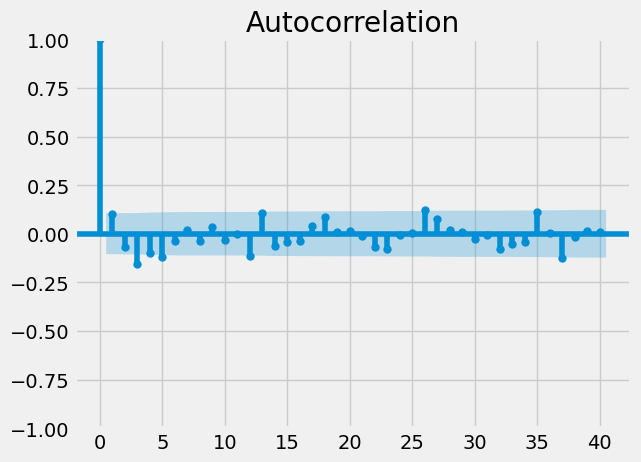

In [49]:
# get best model by RMSE
best_model_name = results_df.iloc[3]['Model'] # choose the 'HW_add_add' model for a more useful visualisation. none_none will just be a straight line
best_params = models[best_model_name]
print(f"Best model from validation: {best_model_name}")

trend, seasonal = best_params

HW_none_none = ExponentialSmoothing(
  train_val, # already defined earlier for Gas Consumption
  trend=trend,
  seasonal=seasonal,
  seasonal_periods=12 if seasonal else None
)

fit_none_none = HW_none_none.fit()

plot_acf(fit_none_none.resid.dropna(), lags=40)  # plot residual ACF
acorr_ljungbox(fit_none_none.resid.dropna(), lags=[12, 24], return_df=True)  # Ljung-Box test

#### Visualise Best Holt-Winters Forecast

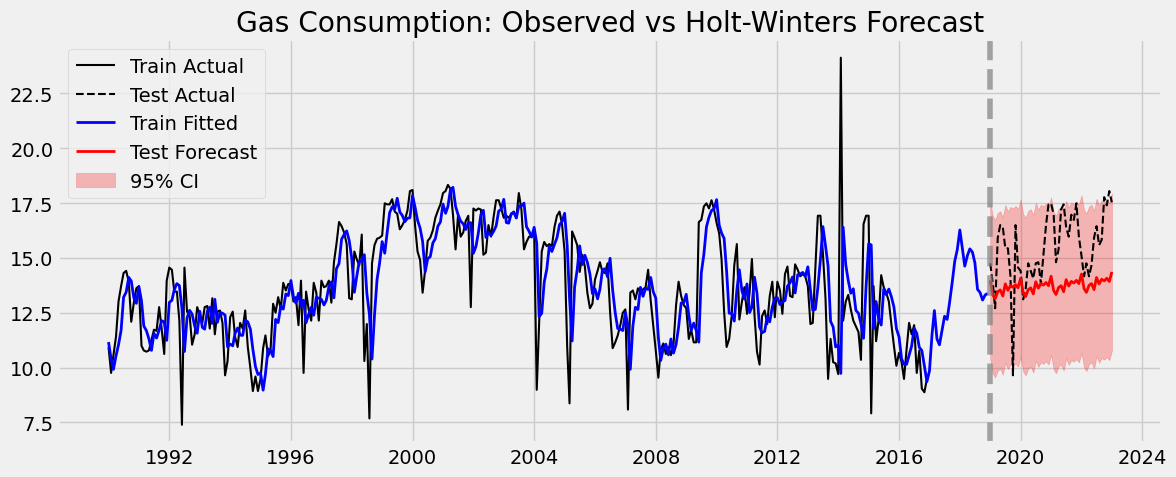

In [50]:
# get training forecast
train_pred = fit_none_none.fittedvalues

# forecast on test set
test_pred = fit_none_none.forecast(steps=len(test_gas))

# approximate confidence intervals
#     Holt-Winters does not provide analytical CI like ARIMA
#     Use residual standard deviation to construct 95% CI
resid_std = fit_none_none.resid.std()
z = 1.96 # 95% confidence level

test_ci_lower = test_pred - z * resid_std
test_ci_upper = test_pred + z * resid_std
test_ci = pd.DataFrame({
  'lower': test_ci_lower,
  'upper': test_ci_upper
})

plt.figure(figsize=(12, 5))
plt.plot(train_gas, label="Train Actual", color="black", linewidth=1.5)
plt.plot(test_gas, label="Test Actual", color="black", linewidth=1.5, linestyle="--")
plt.plot(train_pred, label="Train Fitted", color="blue", linewidth=2)
plt.plot(test_pred, label="Test Forecast", color="red", linewidth=2)

# confidence intervals
plt.fill_between(
  test_ci.index,
  test_ci['lower'], test_ci['upper'],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/test split
plt.axvline(test_gas.index[0], color='gray', linestyle='--', alpha=0.7)

plt.title("Gas Consumption: Observed vs Holt-Winters Forecast")
plt.legend()
plt.tight_layout()
plt.show()

- I chose to visualise **HW_add_add** instead of the best-performing **HW_none_none** to show that Holt-Winters is capable of **capturing both trend and seasonal patterns in the data**, even if it does not achieve the absolute lowest validation error.  

- From the results table:
  - **HW_none_none** has the lowest RMSE (4.666) and MAPE (30.37%), but it only models a **flat level**, ignoring trends or seasonality.
  - **HW_add_add** models **additive trend and additive seasonality**, so its forecast can **follow upward/downward slopes and repeating seasonal patterns**, providing a more realistic representation of gas consumption dynamics.
  
- Justification for this choice:
  1. **Pedagogical / visual clarity:** By showing HW_add_add, readers can visually appreciate how Holt-Winters handles trend and seasonality.
  2. **Interpretability:** Even if HW_add_add performs slightly worse numerically, it demonstrates the **full capability of the model**, making it easier to understand patterns that HW_none_none cannot capture.
  3. **Consistency with domain knowledge:** Gas consumption exhibits **seasonal patterns and long-term trends**, which HW_add_add is designed to model.

→ **Conclusion: In this case, the goal is to illustrate the model's behavior instead of highlighting the lowest error metric.**

#### Try SARIMA
Use only Train dataset to decide best parameters

In [51]:
models = {
  'SARIMA_101_110': (1, 0, 1, 0, 1, 0, 12),  # No seasonal MA
  'SARIMA_101_010': (1, 0, 1, 0, 1, 0, 12),  # No seasonal AR/MA
  'SARIMA_100_111': (1, 0, 0, 1, 1, 1, 12),  # No non-seasonal MA
  'SARIMA_301_311': (3, 0, 1, 3, 1, 1, 12),  # More AR terms
  'SARIMA_103_113': (1, 0, 3, 1, 1, 3, 12),  # More MA terms
  'SARIMA_110_111': (1, 1, 0, 1, 1, 1, 12),  # Try First-Differencing
  'SARIMA_111_111': (1, 1, 1, 1, 1, 1, 12)   # 
}

results = []

for name, (p, d, q, P, D, Q, s) in models.items():
  # fit model
  model = SARIMAX(
    train_gas,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
  )

  fitted = model.fit(disp=False)

  # calculate evaluation metrics
  forecast = fitted.get_forecast(steps=len(val_gas))
  y_pred = forecast.predicted_mean
  rmse = np.sqrt(mean_squared_error(val_gas, y_pred))
  mae = mean_absolute_error(val_gas, y_pred)
  mape = mean_absolute_percentage_error(val_gas, y_pred) * 100

  # Ljung-Box test
  lb_test = acorr_ljungbox(fitted.resid.dropna(), lags=[12], return_df=True)
  lb_pval = lb_test.loc[12, 'lb_pvalue']

  results.append({
    'Model': name,
    'Order': f'({p},{d},{q})({P},{D},{Q},{s})',
    'AIC': fitted.aic,
    'BIC': fitted.bic,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE (%)': mape
  })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['MAPE (%)', 'AIC']).reset_index(drop=True)
results_df

Model              Order          AIC          BIC      RMSE  \
0  SARIMA_100_111  (1,0,0)(1,1,1,12)  1275.437194  1290.238968  1.758506   
1  SARIMA_301_311  (3,0,1)(3,1,1,12)  1164.796107  1197.281353  1.877371   
2  SARIMA_103_113  (1,0,3)(1,1,3,12)  1146.186910  1178.639128  3.056640   
3  SARIMA_111_111  (1,1,1)(1,1,1,12)  1244.216907  1262.685568  3.611547   
4  SARIMA_101_110  (1,0,1)(0,1,0,12)  1480.973727  1492.183444  4.181289   
5  SARIMA_101_010  (1,0,1)(0,1,0,12)  1480.973727  1492.183444  4.181289   
6  SARIMA_110_111  (1,1,0)(1,1,1,12)  1286.444881  1301.233255  4.897587   

        MAE   MAPE (%)  
0  1.440607  10.454187  
1  1.493710  10.551760  
2  2.681394  18.576853  
3  3.312635  23.041321  
4  3.574371  24.410376  
5  3.574371  24.410376  
6  4.613146  32.284041

* SARIMA_100_111 beats all the models in terms of RMSE, MAE and MAPE while heavily compromising on AIC (~1275 compared to the 1st runner-up, SARIMA_301_311, whose MAPE is only 0.01% higher than SARIMA_100_111 but yields the lowest AIC of ~1165).

* SARIMA_301_311 is close behind, indicating that AR terms are important for Gas. MA terms are not as SARIMA_103_113 has ~8% higher MAPE than the Top 2 models.   

* SARIMA_110_111 scored an abysmal MAPE of 32%, telling me that First-differencing is not good for Gas. It likely introduces negative autocorrelations which messes SARIMA up.

→ **I will re-fit SARIMA_300_311 on the train+validation set, then evaluate its final performance on the test set.**

#### Fit Best Model (SARIMA_300_311)
Combine Train + Validation set

Best model from validation: SARIMA_301_311
                                     SARIMAX Results                                      
Dep. Variable:                        gas_tons_bc   No. Observations:                  348
Model:             SARIMAX(3, 0, 1)x(3, 1, 1, 12)   Log Likelihood                -619.258
Date:                            Sun, 08 Feb 2026   AIC                           1256.516
Time:                                    20:46:56   BIC                           1289.760
Sample:                                01-01-1990   HQIC                          1269.825
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4297      1.102      0.390      0.696      -1.729     

lb_stat     lb_pvalue
12  61.152270  1.390574e-08
24  69.220281  2.867942e-06

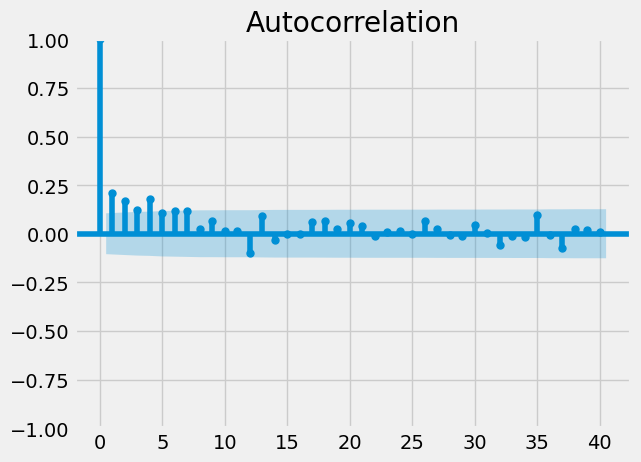

In [52]:
# get best model and params
best_model_name = results_df.iloc[1]['Model'] # use SARIMA_301_311
best_params = models[best_model_name]
print(f"Best model from validation: {best_model_name}")

# join train and validation set for re-fitting
train_val = pd.concat([train_gas, val_gas])
p, d, q, P, D, Q, s = best_params

SARIMA_300_311 = SARIMAX(
  train_val,
  order=(p, d, q),
  seasonal_order=(P, D, Q, s),
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_300_311 = SARIMA_300_311.fit(disp=False)

print(fit_300_311.summary())
plot_acf(fit_300_311.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_300_311.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

#### Visualise Best SARIMA's Forecast
Forecast on Test set

In [53]:
final_forecast = fit_300_311.get_forecast(steps=len(test_gas))
test_pred = final_forecast.predicted_mean

test_rmse = np.sqrt(mean_squared_error(test_gas, test_pred))
test_mae = mean_absolute_error(test_gas, test_pred)
test_mape = mean_absolute_percentage_error(test_gas, test_pred) * 100

print("SARIMA_300_311's Test Performance")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

SARIMA_300_311's Test Performance
RMSE: 2.3258
MAE : 1.9473
MAPE: 12.27%


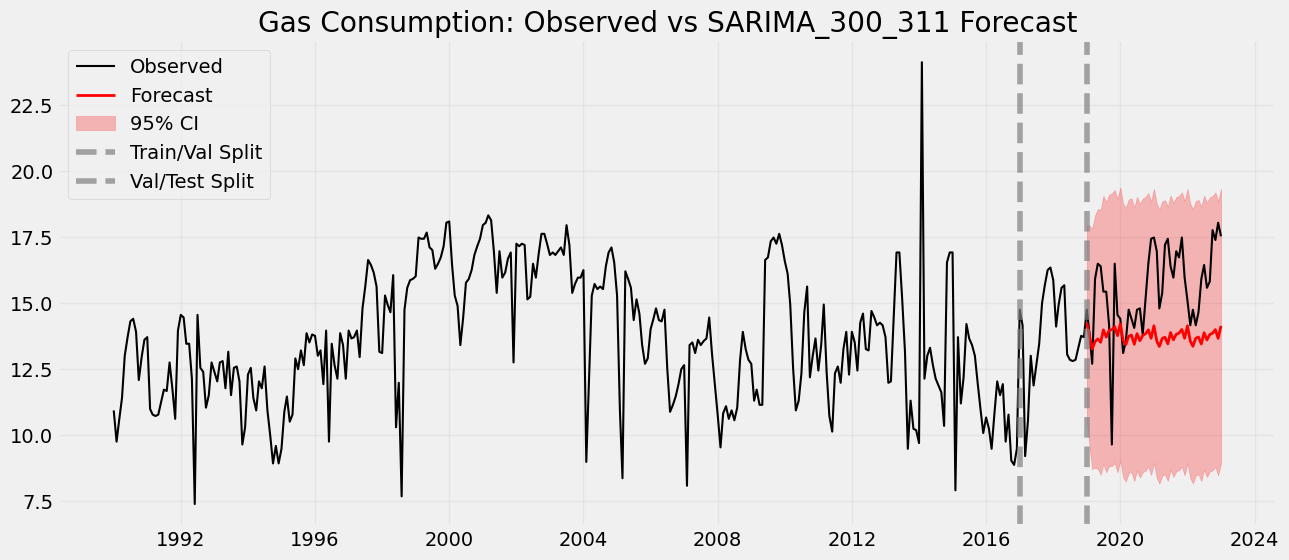

In [54]:
# forecast on test set
test_ci = final_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['gas_tons_bc'], # original series
         label='Observed', color='black', linewidth=1.5)
plt.plot(test_gas.index, test_pred, # test period/forecast
         label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_gas.index,
  test_ci.iloc[:, 0],
  test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/validation/test split
plt.axvline(val_gas.index[0], color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(test_gas.index[0], color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title('Gas Consumption: Observed vs SARIMA_300_311 Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Try A More Volatile SARIMA
Explore models that compromise on accuracy metrics to capture more trend and seasonality than a model that has excellent accuracy by "playing it safe".

In [55]:
SARIMA_101_110 = SARIMAX(
  train_val,
  order=(1, 0, 1),
  seasonal_order=(1, 1, 0, 12),
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_101_110 = SARIMA_101_110.fit(disp=False)

# forecast on test set
forecast_101_110 = fit_101_110.get_forecast(steps=len(test_gas))
test_pred = forecast_101_110.predicted_mean

# calculate evaluation metrics
test_rmse = np.sqrt(mean_squared_error(test_gas, test_pred))
test_mae = mean_absolute_error(test_gas, test_pred)
test_mape = mean_absolute_percentage_error(test_gas, test_pred) * 100

print("SARIMA_101_110's Test Performance")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

SARIMA_101_110's Test Performance
RMSE: 2.3117
MAE : 1.9607
MAPE: 12.58%


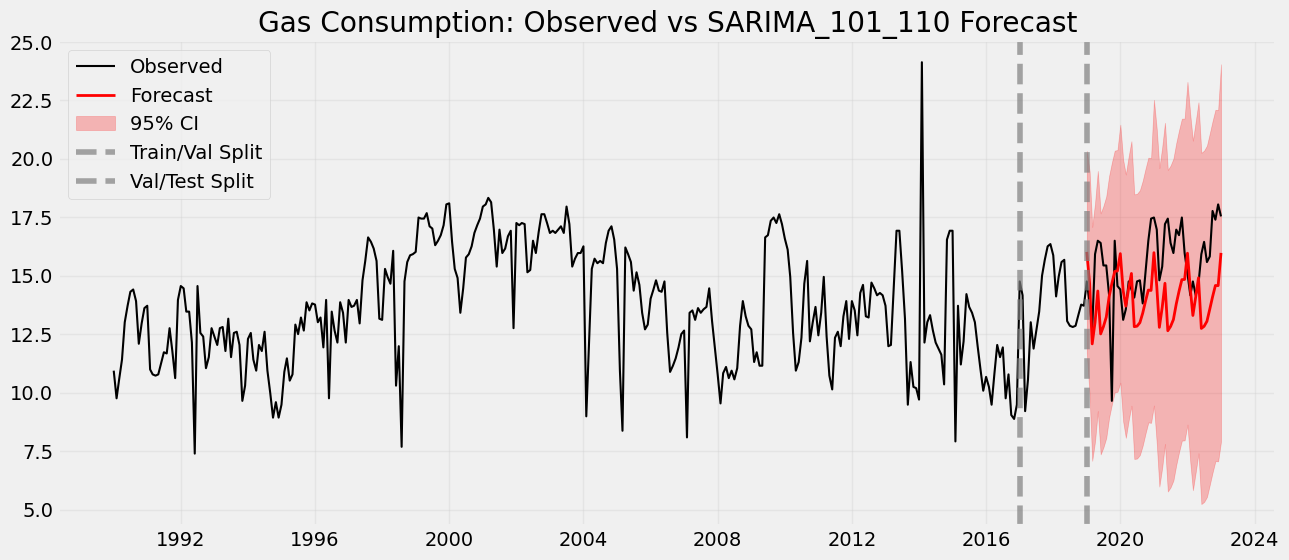

In [56]:
# forecast on test set
test_ci = forecast_101_110.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['gas_tons_bc'], # original series
         label='Observed', color='black', linewidth=1.5)
plt.plot(test_gas.index, test_pred, # test period/forecast
         label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_gas.index,
  test_ci.iloc[:, 0],
  test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/validation/test split
plt.axvline(val_gas.index[0], color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
plt.axvline(test_gas.index[0], color='gray', linestyle='--', alpha=0.7, label='Val/Test Split')

plt.title('Gas Consumption: Observed vs SARIMA_101_110 Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

## **STAGE 4: Model Improvement**

- Hyperparameter Tuning with GridSearch
- Compare new models (SARIMAX, tuned Prophet) vs:
  - Naive Forecast
  - Simple Moving Average

_NOTE(1): I've already incorporated some Model Improvement into the Modelling & Evaluation stage._  
_NOTE(2): I continue to experiment with more advanced variations of existing models (e.g. SARIMA → SARIMAX, or more variations of/tuning Prophet)._

---

### Implementing Exogenous Variables (SARIMAX)
Trying SARIMAX on **Electricity Consumption** and **Gas Consumption**.

### `is_holiday`
Holidays are key driving factors of energy consumption. I used the **holidays** library to get all the Singaporean holidays like Chinese New Year, Deepavali etc. and implemented them as exogeneous variables in SARIMAX.  

In [57]:
import holidays
sg_holidays = holidays.Singapore()
df['is_holiday'] = df.index.map(lambda x: 1 if x in sg_holidays else 0)

### `SMA_n`
Simple Moving Average help to smooth volatile data and help models learn trends over time better.

In [58]:
df.loc[:, "gas_SMA_12"] = df.loc[:, "gas_tons"].rolling(12).mean()
df.loc[:, "gas_SMA_24"] = df.loc[:, "gas_tons"].rolling(24).mean()
df.loc[:, "gas_SMA_48"] = df.loc[:, "gas_tons"].rolling(48).mean()

### Experiment SARIMA for **Electricity** & **Gas** Consumption

**Current Best SARIMAs:**

| Consumption Type | SARIMA Model | Test RMSE | Test MAE | Test MAPE | AIC |
|-----------------|:------------------:|:---------:|:--------:|:--------:|:---:|
| Electricity (Log-Transformed) | SARIMA(0,1,3)(0,1,3,12) | 0.0338 | 0.0261 | 0.38% | Not Applicable |
| Gas (Box-Cox) | SARIMA(1,0,1)(1,1,0,12) | 2.3117 | 1.9607 | 12.58% | Not Applicable |

Let's try and improve these SARIMAs by introducing exogeneous variables, X in SARIMAX!

#### Split New Data

In [59]:
train_end = "2016-12-01"
val_end = "2018-12-01"

# Electricity (logged)
y_elect = df['electricity_mwh_log']
exog_elect = df[['is_holiday']]

train_y_elect = y_elect.loc[:train_end]
val_y_elect   = y_elect.loc[train_end:val_end].iloc[1:]  # skip duplicate date
test_y_elect  = y_elect.loc[val_end:].iloc[1:]

exog_train_elect = exog_elect.loc[train_y_elect.index]
exog_val_elect   = exog_elect.loc[val_y_elect.index]
exog_test_elect  = exog_elect.loc[test_y_elect.index]

# Gas (Box-Cox'ed)
gas_features = ['is_holiday', 'gas_SMA_12', 'gas_SMA_24', 'gas_SMA_48']

y_gas = df['gas_tons_bc']
exog_gas = df[gas_features]

train_y_gas = y_gas.loc[:train_end]
val_y_gas   = y_gas.loc[train_end:val_end].iloc[1:]
test_y_gas  = y_gas.loc[val_end:].iloc[1:]

# combine → drop NaNs → split back
train_gas_full = pd.concat([train_y_gas, exog_gas.loc[train_y_gas.index]], axis=1).dropna()
val_gas_full   = pd.concat([val_y_gas, exog_gas.loc[val_y_gas.index]], axis=1).dropna()
test_gas_full  = pd.concat([test_y_gas, exog_gas.loc[test_y_gas.index]], axis=1).dropna()

train_y_gas = train_gas_full['gas_tons_bc']
val_y_gas   = val_gas_full['gas_tons_bc']
test_y_gas  = test_gas_full['gas_tons_bc']

exog_train_gas = train_gas_full[gas_features]
exog_val_gas   = val_gas_full[gas_features]
exog_test_gas  = test_gas_full[gas_features]

#### Fit & Visualise SARIMAX

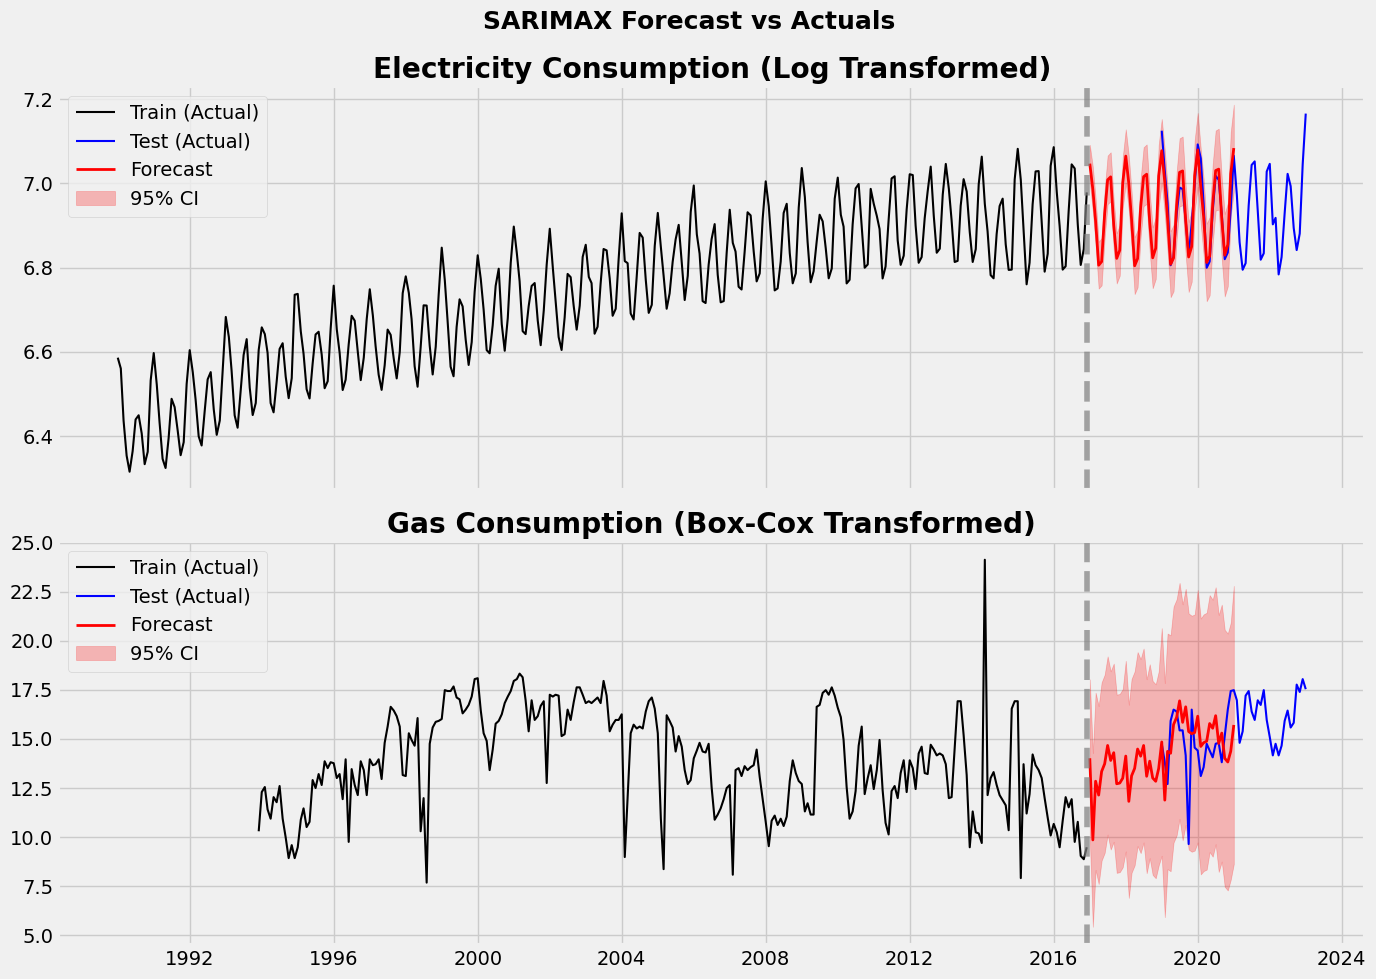

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle("SARIMAX Forecast vs Actuals", fontsize=18, fontweight="bold")

# Electricity (Best: SARIMA_013_013)
model_elect = SARIMAX(train_y_elect, exog=exog_train_elect, order=(0, 1, 3), seasonal_order=(0, 1, 3, 12))
fit_model_elect = model_elect.fit()
fcst_elect = fit_model_elect.get_forecast(steps=len(test_y_elect), exog=exog_test_elect)
y_elect_pred = fcst_elect.predicted_mean # extract the mean of the predictions
ci_elect = fcst_elect.conf_int() # get confidence interval

axes[0].plot(train_y_elect.index, train_y_elect, label="Train (Actual)", color="black", linewidth=1.5)
axes[0].plot(test_y_elect.index, test_y_elect, label="Test (Actual)", color="blue", linewidth=1.5)

axes[0].plot(y_elect_pred.index, y_elect_pred, label="Forecast", color="red", linewidth=2)

axes[0].fill_between(
  ci_elect.index,
  ci_elect.iloc[:, 0], ci_elect.iloc[:, 1],
  color="red", alpha=0.25, label="95% CI"
)

axes[0].axvline(train_y_elect.index[-1], color="gray", linestyle="--", alpha=0.7)
axes[0].set_title("Electricity Consumption (Log Transformed)", fontweight="bold")
axes[0].legend()


# Gas (Best: SARIMA_101_110)
model_gas = SARIMAX(train_y_gas, exog=exog_train_gas, order=(1, 0, 1), seasonal_order=(1, 1, 0, 12))
fit_model_gas = model_gas.fit()
fcst_gas = fit_model_gas.get_forecast(steps=len(test_y_gas), exog=exog_test_gas)
y_gas_pred = fcst_gas.predicted_mean
ci_gas = fcst_gas.conf_int()

axes[1].plot(train_y_gas.index, train_y_gas, label="Train (Actual)", color="black", linewidth=1.5)
axes[1].plot(test_y_gas.index, test_y_gas, label="Test (Actual)", color="blue", linewidth=1.5)

axes[1].plot(y_gas_pred.index, y_gas_pred, label="Forecast", color="red", linewidth=2)

axes[1].fill_between(
  ci_gas.index,
  ci_gas.iloc[:, 0], ci_gas.iloc[:, 1],
  color="red", alpha=0.25, label="95% CI"
)

axes[1].axvline(train_y_gas.index[-1], color="gray", linestyle="--", alpha=0.7)
axes[1].set_title("Gas Consumption (Box-Cox Transformed)", fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

In [61]:
results = {
  "Electricity": (test_y_elect, y_elect_pred),
  "Gas": (test_y_gas, y_gas_pred)
}

# Loop over each series and calculate metrics
for name, (y_true, y_pred) in results.items():
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred) * 100

  print(f"{name} Forecast Performance:")
  print(f"  RMSE: {rmse:.4f}")
  print(f"  MAE: {mae:.4f}")
  print(f"  MAPE: {mape:.2f}%\n")

Electricity Forecast Performance:
  RMSE: 0.0335
  MAE: 0.0244
  MAPE: 0.35%

Gas Forecast Performance:
  RMSE: 2.0697
  MAE: 1.5454
  MAPE: 9.82%



#### Conclusion: SARIMA or SARIMAX?

**Electricity Consumption:**

- Adding holidays as an exogenous variable to SARIMA_111_011 decreased test MAPE by 0.01% (which is a decent improvement as the metrics are on the log-scale)
- No obvious change in confidence intervals
- **Conclusion:** Holidays provide marginal benefit for electricity forecasting.

**Gas Consumption:**

- Adding holidays and SMA features (12, 24, 48-month) to SARIMA_101_110 decreased test MAPE by 2.00% (Box-Cox scale), which is a big improvement!
- Confidence intervals tightened by ~1.5-2.5 tons, indicating more precise predictions.
- **Conclusion:** SARIMAX significantly improved gas consumption forecasts.

**Overall:**  

SARIMAX outperforms SARIMA, particularly for gas consumption. This is expected because:  
1. **Contextual signals matter:** Energy consumption is influenced by real-world events (holidays, seasonal patterns captured by SMAs)
2. **Multi-scale trends:** SMA features (12/24/48-month) provide smoothed historical context that helps the model distinguish noise from genuine consumption patterns
3. **Long-horizon forecasting:** For 60-month forecasts, exogenous variables provide stability by anchoring predictions to known seasonal cycles and reducing drift from pure autoregression

The added complexity of SARIMAX is justified by improved accuracy and tighter uncertainty estimates, making it more reliable for operational planning.

---

### Hyperparameter Tuning

In [62]:
import itertools

# -----------------------------
# define hyperparameter search
# -----------------------------
def sarimax_grid_search(c_type, train, val, exog_train=None, exog_val=None,
                        p_values=range(0,3), d_values=[0,1], q_values=range(0,3),
                        P_values=range(0,3), D_values=[0,1], Q_values=range(0,3), s=12):
  
  best_score = float("inf")
  best_order = None
  best_seasonal_order = None
  results = []
    
  for p,d,q in itertools.product(p_values,d_values,q_values):
    for P,D,Q in itertools.product(P_values,D_values,Q_values):
      try:
        model = SARIMAX(
          train, 
          order=(p,d,q),
          seasonal_order=(P,D,Q,s),
          exog=exog_train,
          enforce_stationarity=False,
          enforce_invertibility=False
        )
        fitted = model.fit(disp=False)
        
        forecast = fitted.get_forecast(steps=len(val), exog=exog_val)
        y_pred = forecast.predicted_mean
        
        rmse = np.sqrt(mean_squared_error(val, y_pred))
        
        results.append({
          "order": (p,d,q),
          "seasonal_order": (P,D,Q,s),
          "rmse": rmse,
          "aic": fitted.aic
        })
        
        if rmse < best_score:
          print(f"{c_type.lower()} | SARIMAX_{p}_{d}_{q}_{P}_{D}_{Q} | RMSE {rmse}")
          best_score = rmse
          best_order = (p,d,q)
          best_seasonal_order = (P,D,Q,s)      
            
      except:
        print(f"SARIMAX_{p}_{d}_{q}_{P}_{D}_{Q} failed")
        continue
  
  results_df = pd.DataFrame(results).sort_values("rmse")
  return best_order, best_seasonal_order, results_df

# -----------------------------
# search best parameters
# -----------------------------
best_order_elect, best_seasonal_elect, results_elect = sarimax_grid_search(
  "Electricity",
  train_y_elect, val_y_elect, exog_train=exog_train_elect, exog_val=exog_val_elect
)

best_order_gas, best_seasonal_gas, results_gas = sarimax_grid_search(
  "Gas",
  train_y_gas, val_y_gas, exog_train=exog_train_gas, exog_val=exog_val_gas
)

print("best electricity params:", best_order_elect, best_seasonal_elect)
print("best gas params:", best_order_gas, best_seasonal_gas)

electricity | SARIMAX_0_0_0_0_0_0 | RMSE 6.153919442490993
electricity | SARIMAX_0_0_0_0_0_1 | RMSE 5.241851431063799
electricity | SARIMAX_0_0_0_0_0_2 | RMSE 3.947001561472685
electricity | SARIMAX_0_0_0_0_1_0 | RMSE 0.03274045827087399
electricity | SARIMAX_0_0_0_0_1_1 | RMSE 0.032722839653827177
electricity | SARIMAX_0_0_0_1_1_0 | RMSE 0.03272231222328561
electricity | SARIMAX_0_0_1_0_1_0 | RMSE 0.02906405212754673
electricity | SARIMAX_0_0_1_0_1_1 | RMSE 0.028502418906682727
electricity | SARIMAX_0_0_2_0_1_0 | RMSE 0.028226320000026554
electricity | SARIMAX_0_0_2_0_1_1 | RMSE 0.02694098637212125
electricity | SARIMAX_0_0_2_1_1_1 | RMSE 0.026895642575529254
electricity | SARIMAX_0_0_2_2_1_0 | RMSE 0.026436764845614927
electricity | SARIMAX_0_1_1_0_1_1 | RMSE 0.025002947567666214
electricity | SARIMAX_0_1_1_0_1_2 | RMSE 0.024638510287664957
gas | SARIMAX_0_0_0_0_0_0 | RMSE 2.181181420276245
gas | SARIMAX_0_0_0_0_0_1 | RMSE 2.153028228016625
gas | SARIMAX_0_0_0_0_1_1 | RMSE 2.01255643

#### Re-fit with Best Params

In [63]:
# -----------------------------
# refit best models on train+val
# -----------------------------
train_val_elect = pd.concat([train_y_elect, val_y_elect])
train_val_gas   = pd.concat([train_y_gas, val_y_gas])
exog_train_val_elect = pd.concat([exog_train_elect, exog_val_elect])
exog_train_val_gas   = pd.concat([exog_train_gas, exog_val_gas])

model_elect_best = SARIMAX(
  train_val_elect,
  order=best_order_elect,
  seasonal_order=best_seasonal_elect,
  exog=exog_train_val_elect,
  enforce_stationarity=False,
  enforce_invertibility=False
)
fit_model_elect_best = model_elect_best.fit(disp=False)

model_gas_best = SARIMAX(
  train_val_gas, 
  order=best_order_gas,
  seasonal_order=best_seasonal_gas,
  exog=exog_train_val_gas,
  enforce_stationarity=False,
  enforce_invertibility=False
)
fit_model_gas_best = model_gas_best.fit(disp=False)

# -----------------------------
# forecast on test set
# -----------------------------
fcst_elect = fit_model_elect_best.get_forecast(steps=len(test_y_elect), exog=exog_test_elect)
y_elect_pred = fcst_elect.predicted_mean
ci_elect = fcst_elect.conf_int()

fcst_gas = fit_model_gas_best.get_forecast(steps=len(test_y_gas), exog=exog_test_gas)
y_gas_pred = fcst_gas.predicted_mean
ci_gas = fcst_gas.conf_int()

# -----------------------------
# evaluate test performance
# -----------------------------
rmse_e = np.sqrt(mean_squared_error(test_y_elect, y_elect_pred))
mae_e = mean_absolute_error(test_y_elect, y_elect_pred)
mape_e = mean_absolute_percentage_error(test_y_elect, y_elect_pred) * 100

rmse_g = np.sqrt(mean_squared_error(test_y_gas, y_gas_pred))
mae_g = mean_absolute_error(test_y_gas, y_gas_pred)
mape_g = mean_absolute_percentage_error(test_y_gas, y_gas_pred) * 100

print(f"electricity test rmse={rmse_e:.3f}, mae={mae_e:.3f}, mape={mape_e:.2f}%")
print(f"gas test rmse={rmse_g:.3f}, mae={mae_g:.3f}, mape={mape_g:.2f}%")

electricity test rmse=0.060, mae=0.053, mape=0.76%
gas test rmse=1.941, mae=1.565, mape=10.04%


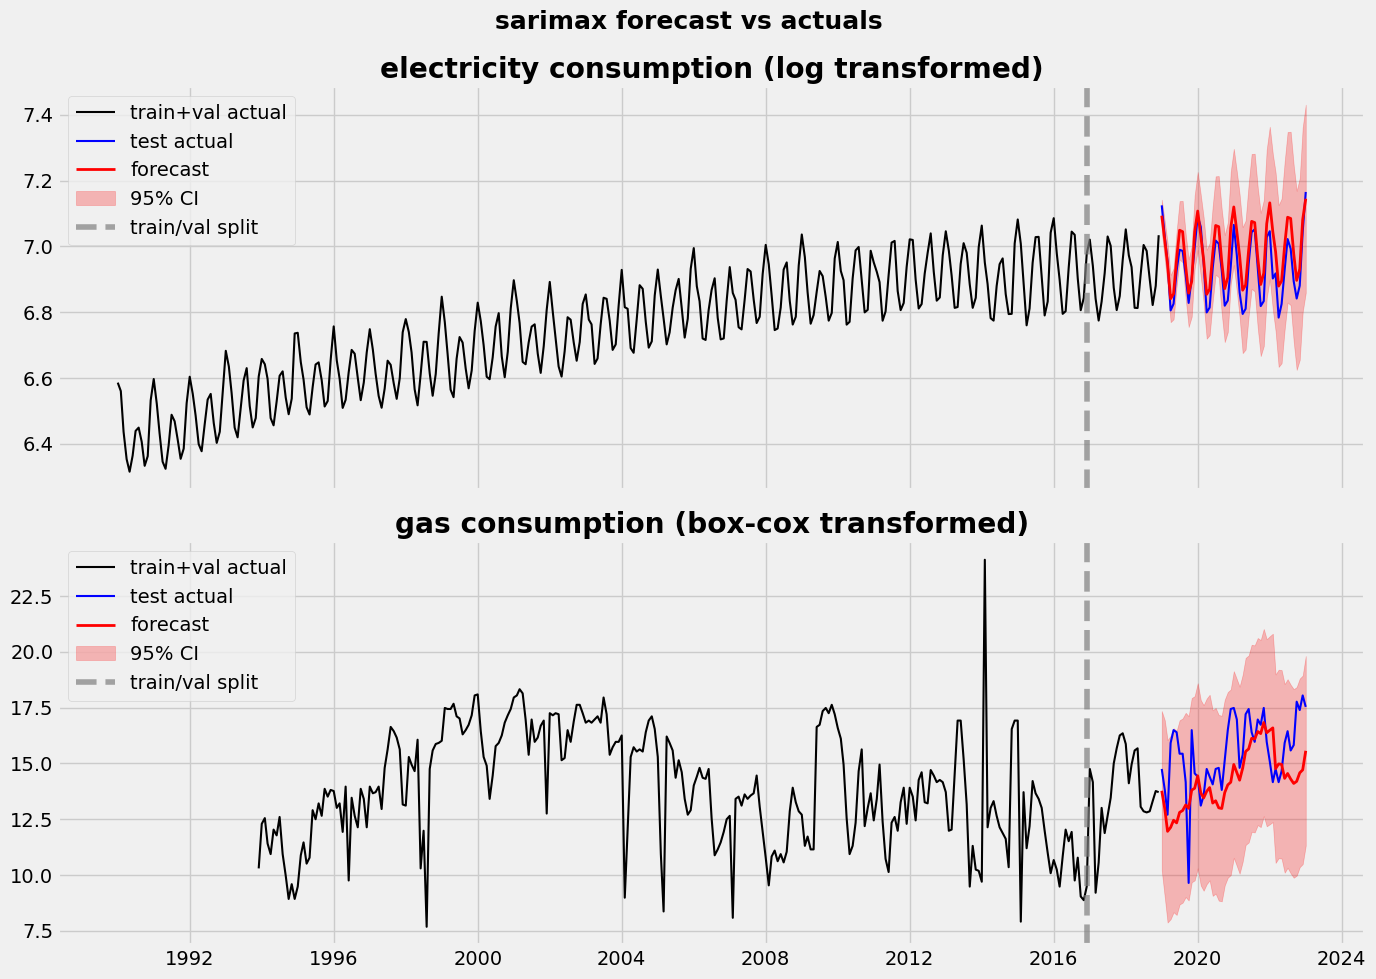

In [64]:
# -----------------------------
# plot forecasts vs actuals
# -----------------------------
fig, axes = plt.subplots(2,1,figsize=(14,10), sharex=True)
fig.suptitle("sarimax forecast vs actuals", fontsize=18, fontweight="bold")

# electricity
axes[0].plot(train_val_elect.index, train_val_elect, label="train+val actual", color="black", linewidth=1.5)
axes[0].plot(test_y_elect.index, test_y_elect, label="test actual", color="blue", linewidth=1.5)
axes[0].plot(y_elect_pred.index, y_elect_pred, label="forecast", color="red", linewidth=2)
axes[0].fill_between(ci_elect.index, ci_elect.iloc[:,0], ci_elect.iloc[:,1], color="red", alpha=0.25, label="95% CI")
axes[0].axvline(train_y_elect.index[-1], color="gray", linestyle="--", alpha=0.7, label="train/val split")
axes[0].set_title("electricity consumption (log transformed)", fontweight="bold")
axes[0].legend()

# gas
axes[1].plot(train_val_gas.index, train_val_gas, label="train+val actual", color="black", linewidth=1.5)
axes[1].plot(test_y_gas.index, test_y_gas, label="test actual", color="blue", linewidth=1.5)
axes[1].plot(y_gas_pred.index, y_gas_pred, label="forecast", color="red", linewidth=2)
axes[1].fill_between(ci_gas.index, ci_gas.iloc[:,0], ci_gas.iloc[:,1], color="red", alpha=0.25, label="95% CI")
axes[1].axvline(train_y_gas.index[-1], color="gray", linestyle="--", alpha=0.7, label="train/val split")
axes[1].set_title("gas consumption (box-cox transformed)", fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

---

### Experiment Outlier Removal on Water Consumption

In [65]:
# extract relevant water consumption columns
water_df = df.copy()
water_df = water_df.loc[:, ['water_tons', 'water_tons_bc', 'water_tons_log']]

# cap at 5th and 95th percentiles (removes extreme 10%)
lower = water_df['water_tons'].quantile(0.05)
upper = water_df['water_tons'].quantile(0.95)
water_df['water_tons_capped'] = water_df['water_tons'].clip(lower=lower, upper=upper)
water_df.head()

water_tons  water_tons_bc  water_tons_log  water_tons_capped
DATE                                                                    
1990-01-01       548.8     687.882895        6.307734              548.8
1990-02-01       640.7     808.562202        6.462561              640.7
1990-03-01       511.1     638.618216        6.236565              511.1
1990-04-01       515.3     644.099121        6.244749              515.3
1990-05-01       488.4     609.028861        6.191135              488.4

In [66]:
split_date = '2018-12-01'
train_capped = water_df.loc[:split_date]
test_capped = water_df.loc[split_date:].iloc[1:]

train_water, test_water = train_capped.loc[:, "water_tons_capped"], test_capped.loc[:, "water_tons_capped"]

In [67]:
models = {
  'Prophet_Default': 
  {
    'growth': 'linear',
    'seasonality_mode': 'additive',
    'yearly_seasonality': 'auto',    # default 
    'weekly_seasonality': 'auto',    # default
    'daily_seasonality': 'auto',     # default
    'changepoint_prior_scale': 0.05  # default
  },

  'Prophet_MultiplicativeSeasonal': 
  {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_prior_scale': 0.05
  },

  'Prophet_FlexibleTrend':
  {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_prior_scale': 0.5
  },

  'Prophet_LessFlexibleTrend': 
  {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_prior_scale': 0.01
  },
}


In [68]:
def prepare_prophet_data(data):
  """Convert time series (Series) to Prophet format"""
  prophet_df = pd.DataFrame({
    'ds': data.index,
    'y': data.values
  })
  return prophet_df

# Prophet train and test data
train_prophet = prepare_prophet_data(train_water)
test_prophet = prepare_prophet_data(test_water)

results = []
fitted_models = {}

for model_name, params in models.items():
  # fit model
  model = Prophet(**params)
  model.fit(train_prophet)

  # forecast on test set
  future = model.make_future_dataframe(periods=len(test_prophet), freq='MS')
  forecast = model.predict(future)
  test_pred = forecast.iloc[-len(test_prophet):]['yhat'].values
  
  # calculate evaluation metrics
  rmse = np.sqrt(mean_squared_error(test_prophet['y'], test_pred))
  mae = mean_absolute_error(test_prophet['y'], test_pred)
  mape = mean_absolute_percentage_error(test_prophet['y'], test_pred) * 100
  
  # get training MSE
  train_pred = forecast.iloc[:len(train_prophet)]['yhat'].values
  train_mse = mean_squared_error(train_prophet['y'], train_pred)
  
  results.append({
    'Model': model_name,
    'Growth': params['growth'],
    'Seasonality': params['seasonality_mode'],
    'Changepoint_Prior': params['changepoint_prior_scale'],
    'Train_MSE': train_mse,
    'Test_RMSE': rmse,
    'Test_MAE': mae,
    'MAPE (%)': mape
  })
  
  fitted_models[model_name] = {
    'model': model,
    'forecast': forecast
  }

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['MAPE (%)', 'Test_RMSE'])
results_df

21:04:13 - cmdstanpy - INFO - Chain [1] start processing
21:04:13 - cmdstanpy - INFO - Chain [1] done processing
21:04:13 - cmdstanpy - INFO - Chain [1] start processing
21:04:13 - cmdstanpy - INFO - Chain [1] done processing
21:04:13 - cmdstanpy - INFO - Chain [1] start processing
21:04:14 - cmdstanpy - INFO - Chain [1] done processing
21:04:14 - cmdstanpy - INFO - Chain [1] start processing
21:04:14 - cmdstanpy - INFO - Chain [1] done processing


Model  Growth     Seasonality  Changepoint_Prior  \
2           Prophet_FlexibleTrend  linear  multiplicative               0.50   
0                 Prophet_Default  linear        additive               0.05   
3       Prophet_LessFlexibleTrend  linear  multiplicative               0.01   
1  Prophet_MultiplicativeSeasonal  linear  multiplicative               0.05   

      Train_MSE   Test_RMSE    Test_MAE   MAPE (%)  
2   8996.051896  108.127357   84.152289  17.052836  
0  10897.356132  110.624557   89.525920  20.981178  
3  14131.303839  111.804848   89.568551  21.114345  
1  12144.684226  127.875127  106.262911  25.324891

In [69]:
best_model_name = results_df.iloc[0]['Model']
best_model = fitted_models[best_model_name]['model']
best_forecast = fitted_models[best_model_name]['forecast']
print(f"Best Prophet: {best_model_name}")

# Ljung-Box test
train_forecast_values = best_forecast.iloc[:len(train_prophet)]['yhat'].values
train_residuals = train_prophet['y'].values - train_forecast_values
lb_result = acorr_ljungbox(train_residuals, lags=[12, 24], return_df=True)
lb_result

Best Prophet: Prophet_FlexibleTrend


lb_stat     lb_pvalue
12  136.628866  2.866062e-23
24  197.352179  3.399534e-29

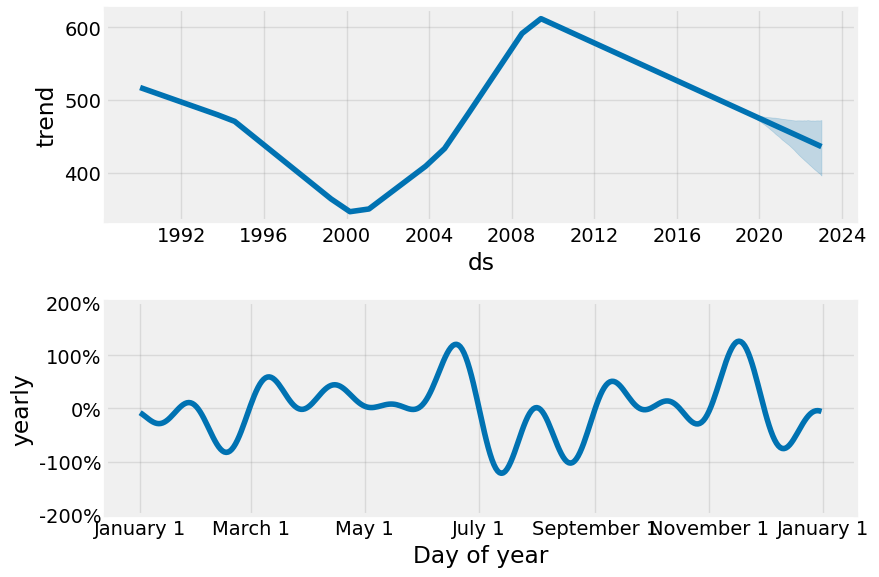

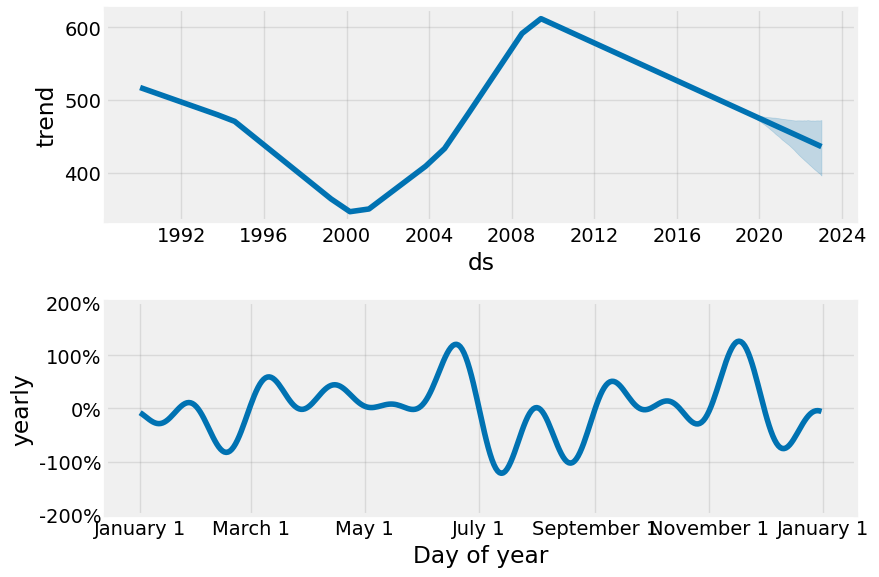

In [70]:
best_model.plot_components(best_forecast)

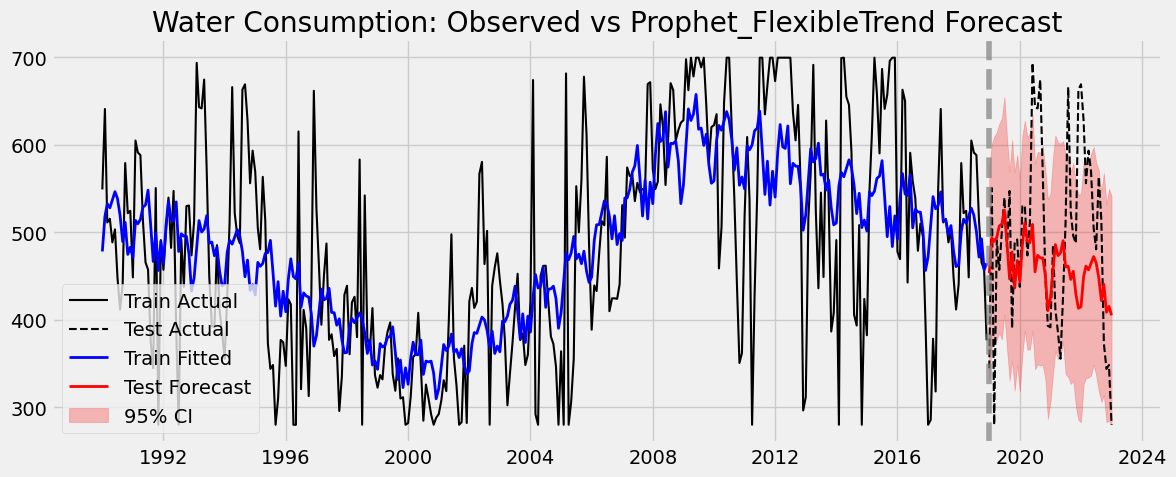

In [71]:
# get train forecast
train_forecast = best_forecast.iloc[:len(train_prophet)]['yhat']

# get test forecast
test_forecast_values = best_forecast.iloc[len(train_prophet):len(train_prophet)+len(test_prophet)]['yhat']
test_forecast_lower = best_forecast.iloc[len(train_prophet):len(train_prophet)+len(test_prophet)]['yhat_lower']
test_forecast_upper = best_forecast.iloc[len(train_prophet):len(train_prophet)+len(test_prophet)]['yhat_upper']

plt.figure(figsize=(12, 5))
plt.plot(train_prophet['ds'], train_prophet['y'], label="Train Actual", color="black", linewidth=1.5)
plt.plot(test_prophet['ds'], test_prophet['y'], label="Test Actual", color="black", linewidth=1.5, linestyle="--")
plt.plot(train_prophet['ds'], train_forecast, label="Train Fitted", color="blue", linewidth=2)
plt.plot(test_prophet['ds'], test_forecast_values, label="Test Forecast", color="red", linewidth=2)

# confidence interval
plt.fill_between(
  test_prophet['ds'],
  test_forecast_lower, test_forecast_upper,
  color='red', alpha=0.25, label='95% CI'
)

# mark train/test split
plt.axvline(test_prophet['ds'].iloc[0], color='gray', linestyle='--', alpha=0.7)

plt.title("Water Consumption: Observed vs Prophet_FlexibleTrend Forecast")
plt.legend()
plt.tight_layout()
plt.show()

---

## STAGE 4.1: 60-month Future Forecast
Fulfilling the assignment task.

**Tuning Results**  
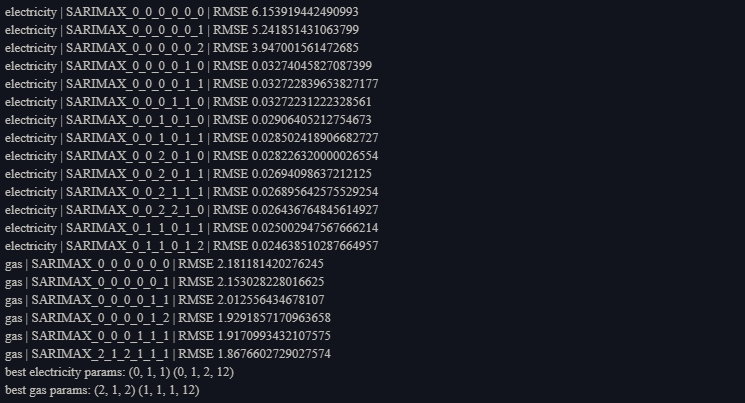

---

### **Electricity Consumption (SARIMAX_111_011 w/ holidays)**
- Re-fit model on all data  
- Forecast 60 months into the future
- Inverse log-transform
- Plot

#### Re-fit On All Data

In [81]:
y_elect_full = df['electricity_mwh_log']

# prepare exogeneous data (hoildays)
exog_vars_elect_full = df[['is_holiday']]

# fit model
model_elect_full = SARIMAX(
  y_elect_full,
  exog=exog_vars_elect_full,
  order=(0, 1, 1),
  seasonal_order=(0, 1, 2, 12)
)
fit_elect_full = model_elect_full.fit()

#### Forecast

In [82]:
# create future 60-month index
future_index = pd.date_range(
  start=y_elect_full.index[-1] + pd.offsets.MonthBegin(),
  periods=60, freq="MS"
)

# create future exogenous variables by replicating last 5 years of holiday pattern
future_exog_elect = pd.concat([df[['is_holiday']].iloc[-12:]] * 5).head(60)
future_exog_elect.index = future_index

# forecast
future_fcst_elect = fit_elect_full.get_forecast(steps=60, exog=future_exog_elect)
future_pred_log = future_fcst_elect.predicted_mean
future_ci_log = future_fcst_elect.conf_int()

# align the dates
future_pred_log.index = future_index
future_ci_log.index = future_index

# inverse log-transform to convert logged predictions to original scale
future_pred_elect = np.exp(future_pred_log)
future_ci_elect = np.exp(future_ci_log)
past_data_elect = np.exp(y_elect_full)

#### Re-fit On All Data

#### Visualise

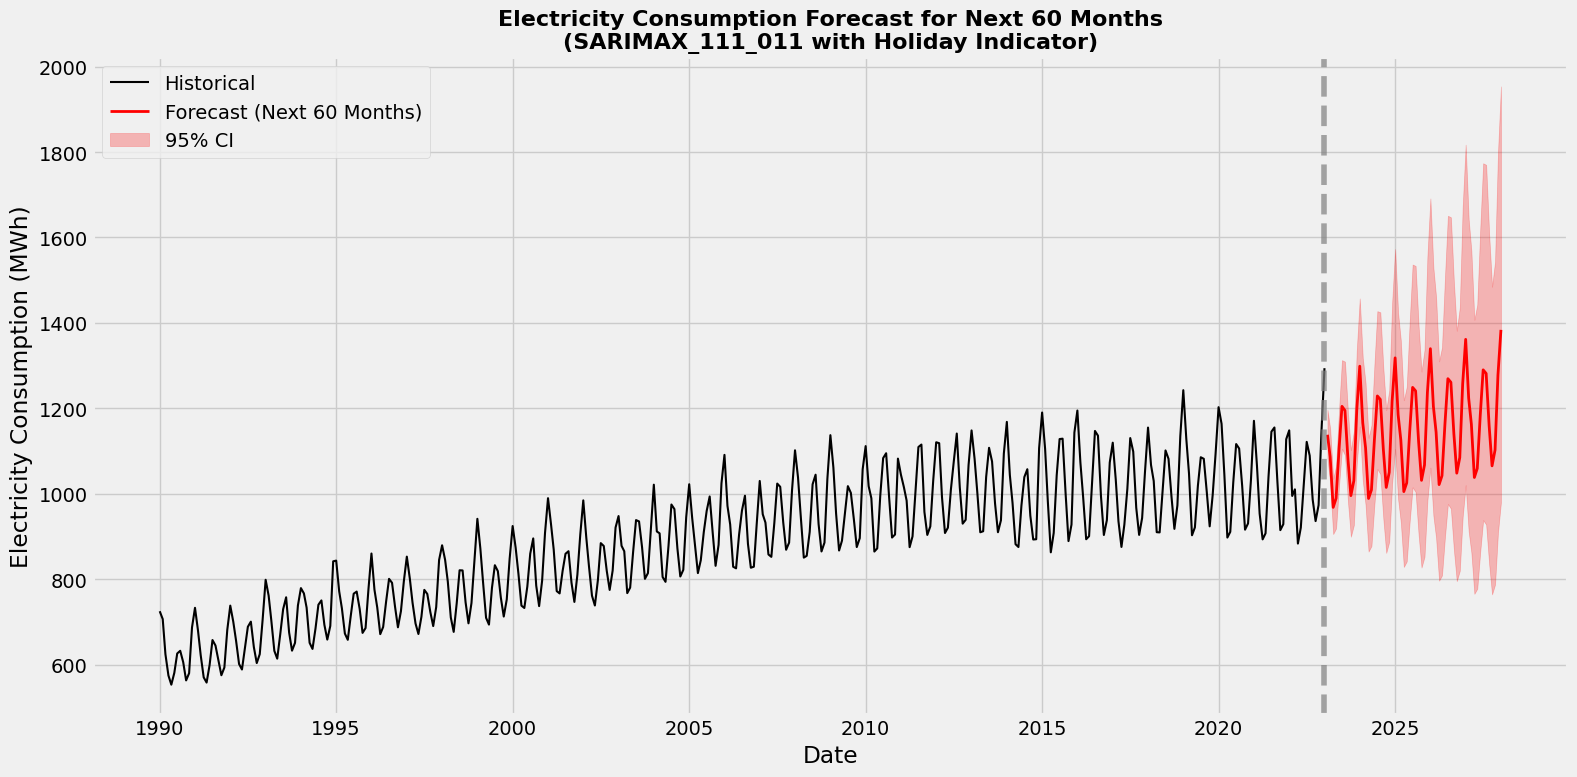

In [83]:
plt.figure(figsize=(16, 8))

# plot past to future data
plt.plot(past_data_elect, label="Historical", color="black", linewidth=1.5)
plt.plot(future_pred_elect, label="Forecast (Next 60 Months)", color="red", linewidth=2)

# plot confidence interval
plt.fill_between(
  future_ci_elect.index,
  future_ci_elect.iloc[:, 0], future_ci_elect.iloc[:, 1],
  color="red", alpha=0.25, label="95% CI"
)

plt.axvline(y_elect_full.index[-1], color="gray", linestyle="--", alpha=0.7)

plt.title("Electricity Consumption Forecast for Next 60 Months\n(SARIMAX_111_011 with Holiday Indicator)",
          fontweight="bold", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Electricity Consumption (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

---

### **Water Consumption (Prophet_FlexibleTrend)**
- Re-fit model on **winsorized** Water Consumption data  
- Forecast 60 months into the future
- Plot

#### Re-fit On All Data
Do not use Winsorized Water Consumption Data (`water_tons_capped`) as it was only meant for model fitting.

In [75]:
y_water_full = water_df['water_tons']

# prepare Prophet data using preparation function created above
water_prophet_full = prepare_prophet_data(y_water_full)

# fit model using best parameters
model_water_full = Prophet(
  growth='linear',
  seasonality_mode='multiplicative',
  yearly_seasonality=True,
  weekly_seasonality=False,
  daily_seasonality=False,
  changepoint_prior_scale=0.5  # FlexibleTrend parameters
)
model_water_full.fit(water_prophet_full)

21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing


#### Forecast

In [76]:
# create future 60-month dataframe
future_water = model_water_full.make_future_dataframe(periods=60, freq='MS')

# forecast
future_fcst_water = model_water_full.predict(future_water)

# extract future 60-month predictions
future_index = future_fcst_water['ds'].iloc[-60:]

# get future data and confidence interval
future_pred_water = future_fcst_water['yhat'].iloc[-60:].values
future_ci_lower = future_fcst_water['yhat_lower'].iloc[-60:].values
future_ci_upper = future_fcst_water['yhat_upper'].iloc[-60:].values

# extract historical data
past_data_water = y_water_full

#### Visualise

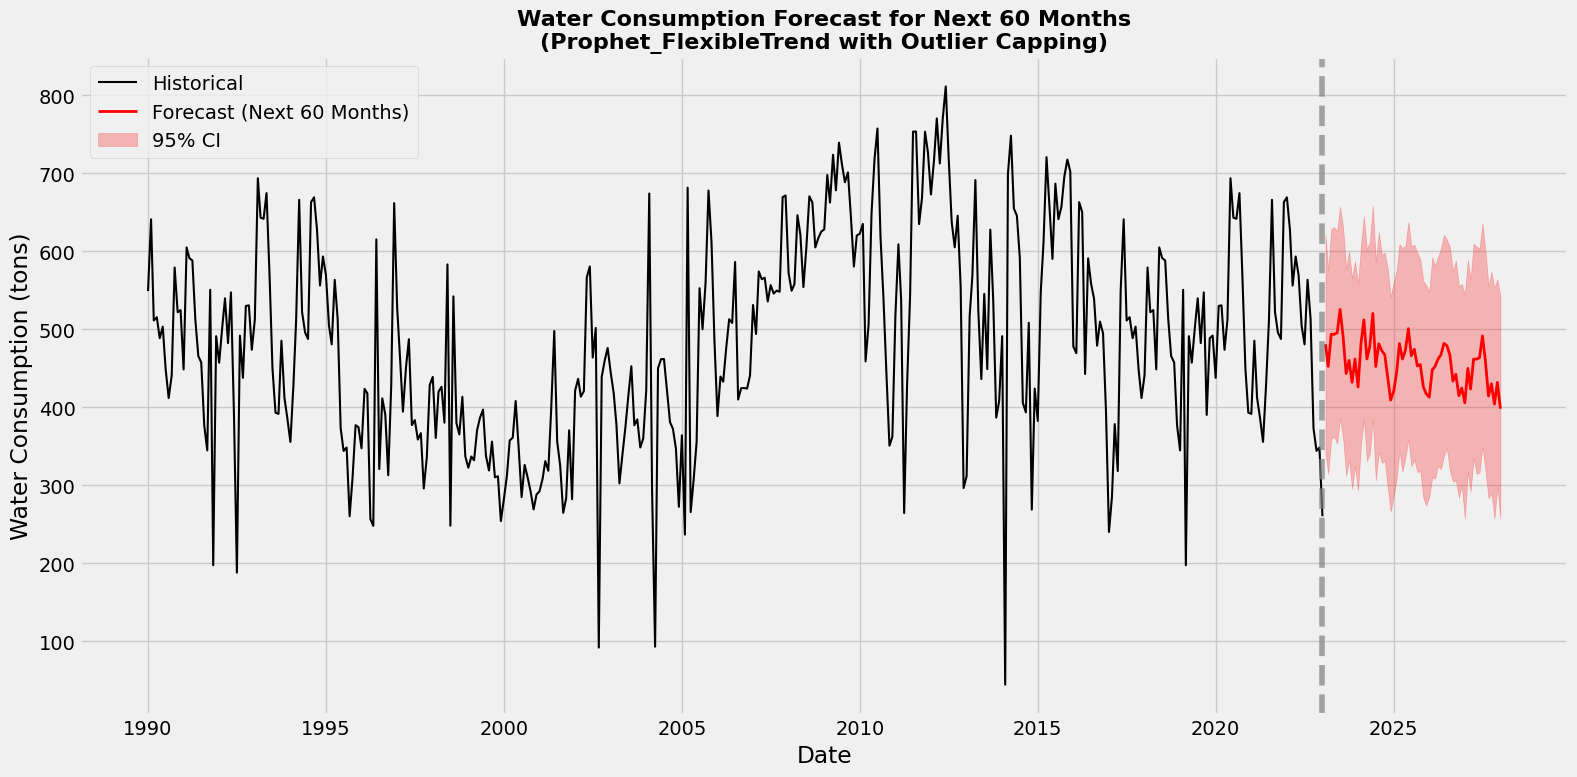

In [77]:
plt.figure(figsize=(16, 8))

# plot past to future data
plt.plot(past_data_water.index, past_data_water, 
         label="Historical", color="black", linewidth=1.5)
plt.plot(future_index, future_pred_water, 
         label="Forecast (Next 60 Months)", color="red", linewidth=2)

# plot confidence interval
plt.fill_between(
  future_index,
  future_ci_lower, future_ci_upper,
  color="red", alpha=0.25, label="95% CI"
)

# mark historical/future split
plt.axvline(y_water_full.index[-1], color="gray", linestyle="--", alpha=0.7)

plt.title("Water Consumption Forecast for Next 60 Months\n(Prophet_FlexibleTrend with Outlier Capping)",
          fontweight="bold", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Water Consumption (tons)")
plt.legend()
plt.tight_layout()
plt.show()

---

### **Gas Consumption (SARIMAX_101_110 w/ holidays, SMA 12, 24, 48)**
- Re-fit model on all data  
- Forecast 60 months into the future
- Inverse Box-Cox transform
- Plot

#### Re-fit On All Data

In [84]:
y_gas_full = df['gas_tons_bc']

# prepare exogeneous data (holidays, SMA)
exog_vars_gas_full = df[['is_holiday', 'gas_SMA_12', 'gas_SMA_24', 'gas_SMA_48']]
full_gas = pd.concat([y_gas_full, exog_vars_gas_full], axis=1).dropna()
y_gas_full = full_gas['gas_tons_bc']
exog_gas_full = full_gas[['is_holiday', 'gas_SMA_12', 'gas_SMA_24', 'gas_SMA_48']]

# fit model
model_gas_full = SARIMAX(
  y_gas_full,
  exog=exog_gas_full,
  order=(2, 1, 2),
  seasonal_order=(1, 1, 1, 12)
)
fit_gas_full = model_gas_full.fit()

#### Forecast

In [85]:
# create future 60-month index
future_index_gas = pd.date_range(
  start=y_gas_full.index[-1] + pd.offsets.MonthBegin(),
  periods=60, freq="MS"
)

# create future exogenous variables by replicating last 5 years of holiday pattern
holiday_pattern = df[['is_holiday']].iloc[-12:].values.flatten()
future_holidays = np.tile(holiday_pattern, 5)[:60] # repeat 5 times, take first 60. outputs values instead of a DataFrame

future_exog_gas = pd.DataFrame({
  'is_holiday': future_holidays,
  'gas_SMA_12': [exog_gas_full['gas_SMA_12'].iloc[-1]] * 60,
  'gas_SMA_24': [exog_gas_full['gas_SMA_24'].iloc[-1]] * 60,
  'gas_SMA_48': [exog_gas_full['gas_SMA_48'].iloc[-1]] * 60
}, index=future_index_gas)

# forecast
future_fcst_gas = fit_gas_full.get_forecast(steps=60, exog=future_exog_gas)
future_pred_bc = future_fcst_gas.predicted_mean
future_ci_bc = future_fcst_gas.conf_int()

# align the dates
future_pred_bc.index = future_index_gas
future_ci_bc.index = future_index_gas

# inverse Box-Cox transform to convert predictions to original scale
lambda_gas = lambdas_bc["gas_tons"]  # use the box-cox lambda value from the Preprocessing stage
future_pred_gas = inv_boxcox(future_pred_bc, lambda_gas)
future_ci_gas = inv_boxcox(future_ci_bc, lambda_gas)
past_data_gas = inv_boxcox(y_gas_full, lambda_gas)

#### Visualise

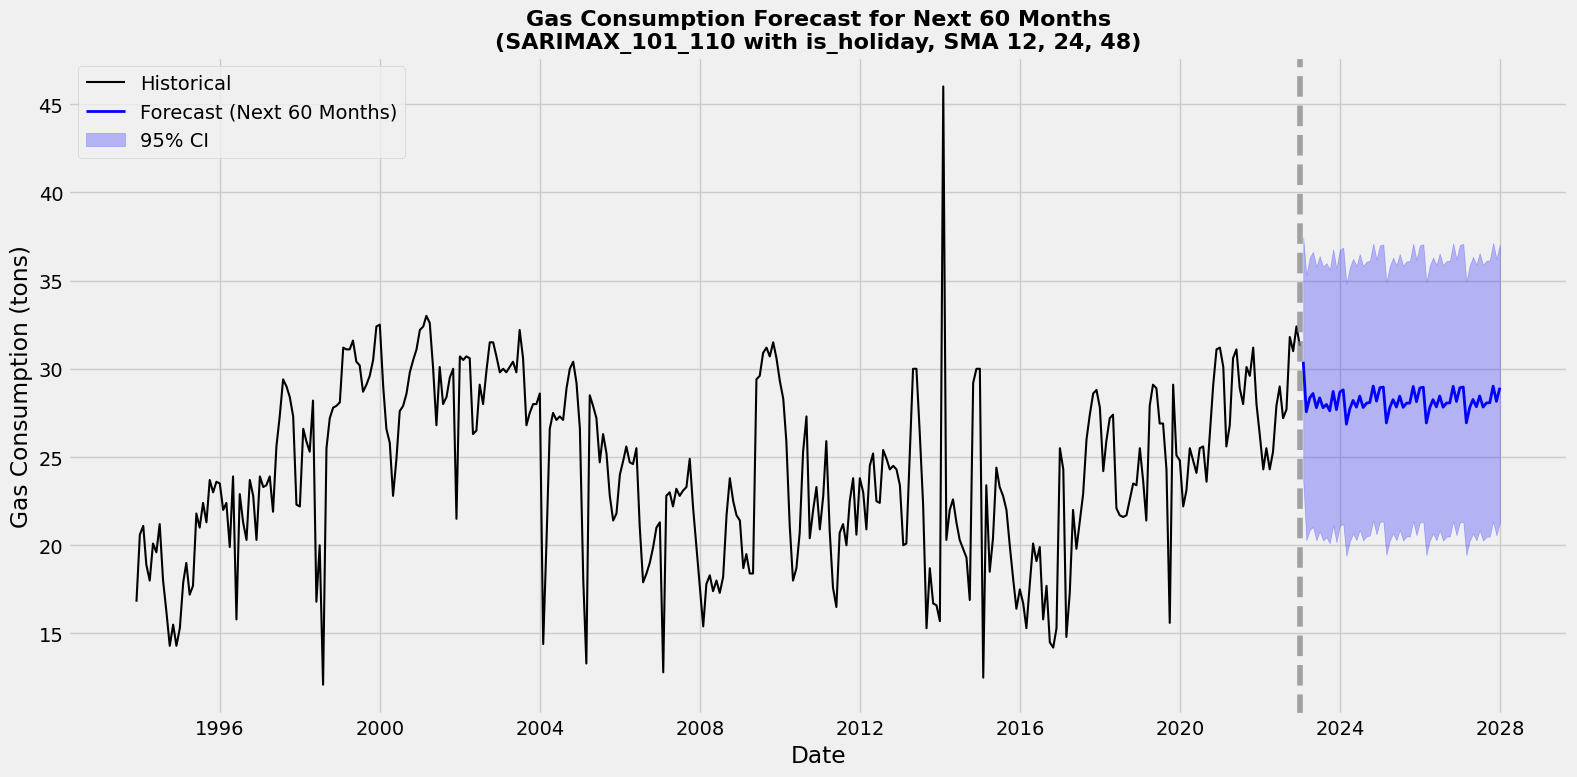

In [86]:
plt.figure(figsize=(16, 8))

# plot past to future data
plt.plot(past_data_gas, label="Historical", color="black", linewidth=1.5)
plt.plot(future_pred_gas, label="Forecast (Next 60 Months)", color="blue", linewidth=2)

# plot confidence interval
plt.fill_between(
  future_ci_gas.index,
  future_ci_gas.iloc[:, 0], future_ci_gas.iloc[:, 1],
  color="blue", alpha=0.25, label="95% CI"
)

plt.axvline(y_gas_full.index[-1], color="gray", linestyle="--", alpha=0.7)

plt.title("Gas Consumption Forecast for Next 60 Months\n(SARIMAX_101_110 with is_holiday, SMA 12, 24, 48)",
          fontweight="bold", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Gas Consumption (tons)")
plt.legend()
plt.tight_layout()
plt.show()